In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
import statsmodels.tsa.stattools as statstools
import statsmodels.tsa.seasonal as seasonal
import itertools

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# model selection
from sklearn.model_selection import LeaveOneGroupOut, GroupShuffleSplit
from sklearn import metrics
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import SVC, NuSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from scipy import interp

# pre-processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder

In this notebook, I visualize and classify data from the MHEALTH dataset, which is available under this link: http://archive.ics.uci.edu/ml/datasets/mhealth+dataset. This dataset was provided for the purpose of **classifying body movements of test subjects** based on a variety of sensor data that was collected via body sensors placed on the chest, wrist and ankle. Hence, this task belongs to the problem domain of Human **Activity Recognition**.

Information about the data:
The sensors measure the motion experienced by diverse body parts, namely acceleration, rate of turn and magnetic field orientation. The sensor positioned on the chest also provides 2-lead ECG measurements, which can be potentially used for basic heart monitoring, checking for various arrhythmias or looking at the effects of exercise on the ECG. Some explanation about the data that is collected:

 - **Acceleration**: An accelerometer is a device that measures acceleration, which is the change in an object's velocity per second. Since velocity is measured in meters per second (m/s), acceleration is measured in meters per second per second, which is written as meters per second squared (m/s2). Positive values indicate an *increase* in velocity, negative values a *decrease*, and zero values indicate constant velocity. Accelerometers measure in the x, y and z directions separately. (https://www.sciencebuddies.org/science-fair-projects/references/accelerometer). Acceleration depends on gravity, which is why depending on orientation, the X, Y, and Z accelerometers can have a non-zero acceleration readings (- 9,8 m/s2) even when not moving.
 
- **Turn rate**: A gyroscope measures the rate of rotation in deg/s around the x,y and z axes. For any positive axis on the device, clockwise rotation outputs negative values, and counterclockwise rotation outputs positive values. (https://de.mathworks.com/help/supportpkg/android/ref/gyroscope.html)  


- **Magnetic Field Orientation**: A magnetometer block reads the strength of the magnetic field around a sensor device along the x,y and z axes.


This notebook consists of two major parts, the first being an **exploratory data analysis** and the second being the **modelling** part in which I try to learn machine learning models that predict the physical activity performed by a test subject based on the multimodal sensing data. But before we jump right into EDA, the data needs to be read in. We are provided with one log file per test subject that contains each subject's measurements. Let's create a function that reads in the log file into a pandas dataframe so that subsequently, all measurements can be merged.

In [218]:
# Define appropriate column names for the measurement dataframes 
columns = ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'ecg_1', 'ecg_2', 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
          'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z', 'mfo_ankle_x', 'mfo_ankle_y', 'mfo_ankle_z', 'acc_wrist_x', 'acc_wrist_y', 'acc_wrist_z',
          'gyro_wrist_x', 'gyro_wrist_y', 'gyro_wrist_z', 'mfo_wrist_x', 'mfo_wrist_y', 'mfo_wrist_z', 'activity']

In [219]:
# Load a subject's measurements into a pandas dataframe 
def load_subject_df(subject_number):
    if subject_number > 10:
        raise ValueError('Number needs to be from 1 to 10')
    
    with open(f'mHealth_subject{subject_number}.log', 'r') as f:
        measurements = f.readlines()
    measurements = [line.split() for line in measurements]
    subject_df = pd.DataFrame(measurements, columns=columns)
    
    # Convert all columns to type float apart from the label 
    for col in subject_df.columns[:-1]:
        subject_df[col] = subject_df[col].astype(float)
    subject_df['activity'] = subject_df['activity'].astype(int)
    subject_df['subject'] = subject_number

    return subject_df

In [227]:
# Read in all logs and concatenate them into a single dataframe
dfs = []
for i in range(1,11):
    df = load_subject_df(i)
    dfs.append(df)
all_subjects = pd.concat(dfs)

# Exploratory Data Analysis

In [228]:
nrows, ncols = all_subjects.shape
print(f'The dataframe has {nrows} rows and {ncols} columns.')

The dataframe has 1215745 rows and 25 columns.


Let's check the distribution of the label

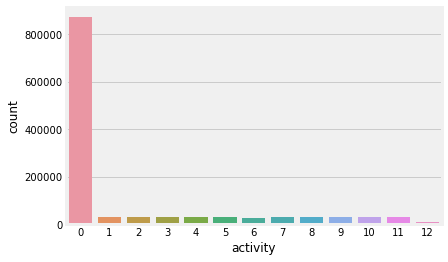

In [229]:
sns.countplot(data=all_subjects, x='activity')
plt.show()

Thea activity encoded by 0 dominates by a huge margin. However, looking at the data description, there is no activity corresponding to label 0. Hence, I assume that all measurements with label 0 correspond have been collected between the actual measurement periods in which test subjects had to perform a specific activity. Thus, all instances with activity 0 will be discarded.

In [302]:
# Discard instances with activity == 0
all_subjects = all_subjects.loc[all_subjects.activity != 0]
nrows, ncols = all_subjects.shape
print(f'The dataframe has {nrows} rows and {ncols} columns.')

The dataframe has 343195 rows and 25 columns.


Only 343195 or around 28 % of the original instances remain.

In [299]:
# Since the activity labels are incoded, let's create an index with the actual labels that we can use in visualizations

# Helper function to map label to string
def map_activity(number):
    activities = {
    1: 'Standing',
    2: 'Sitting',
    3: 'Lying down',
    4: 'Walking',
    5: 'Climbing stairs',
    6: 'Waist bending',
    7: 'Arm elevation',
    8: 'Knees bending',
    9: 'Cycling',
    10: 'Jogging',
    11: 'Running',
    12: 'Jumps' 
                }
    return activities.get(number)

activities_index = [map_activity(act) for act in set(all_subjects.activity)] 

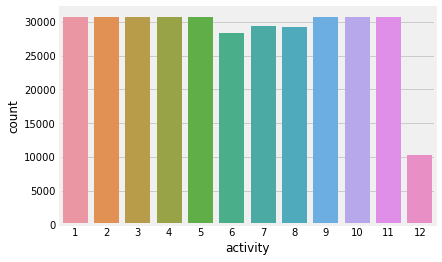

In [305]:
ax = sns.countplot(data=all_subjects, x='activity')
plt.show()

In [223]:
all_subjects.activity.value_counts()

11    160
10    160
9     160
5     160
4     160
3     160
2     160
1     160
7     152
8     151
6     147
12     60
Name: activity, dtype: int64

The activities waist bending, arm elevation, and knees bending have slighlty less and activity jumping front and back has significantly less datapoints, only about one third compared to all other activities. All mentioned activities correspond to activities for which the execution instruction was not based on time (e.g. "Walk for 1 minute"), but on frequency (e.g. "Elevate your arms 20 times"). As the method of measurement is time based with 50 Hz (equal to collecting 50 instances per second), we observe differences. (Correct?)

Let's take a look at the summary statistics of the data:

In [307]:
descriptive_stats = all_subjects.drop(['activity', 'subject'], axis=1).describe()

descriptive_stats

acc_chest_x    acc_chest_y    acc_chest_z          ecg_1  \
count  343195.000000  343195.000000  343195.000000  343195.000000   
mean       -7.485271      -0.140923      -0.938418       0.003649   
std         5.701949       2.799380       4.611164       0.839074   
min       -22.438000     -20.188000     -18.401000      -8.619600   
25%        -9.707100      -1.294300      -3.686550      -0.213500   
50%        -8.800300      -0.292570      -0.881070      -0.071167   
75%        -5.117400       0.984775       1.092650       0.163270   
max        19.094000      20.927000      26.196000       8.506500   

               ecg_2    acc_ankle_x    acc_ankle_y    acc_ankle_z  \
count  343195.000000  343195.000000  343195.000000  343195.000000   
mean       -0.008048       1.805184      -9.061487      -0.701985   
std         0.857724       4.214175       5.200389       6.457622   
min        -8.619600     -22.146000     -19.619000     -19.373000   
25%        -0.171640       0.159875     -10.063000      -3.494350   
50%        -0.046049       1.372500      -9.597700       0.340070   
75%         0.138150       2.924450      -7.549800       1.819300   
max         8.519100      20.024000      21.161000      25.015000   

        gyro_ankle_x   gyro_ankle_y  ...    mfo_ankle_z    acc_wrist_x  \
count  343195.000000  343195.000000  ...  343195.000000  343195.000000   
mean        0.101167      -0.549942  ...      -0.379955      -3.448201   
std         0.458913       0.434721  ...      18.898494       5.891595   
min        -1.779200      -2.660400  ...    -282.390000     -22.345000   
25%        -0.345080      -0.810510  ...      -1.762950      -5.013900   
50%         0.204080      -0.688560  ...      -0.303300      -2.480000   
75%         0.487940      -0.487800  ...       1.570500      -0.539050   
max         1.710600       1.752300  ...     272.560000      19.801000   

         acc_wrist_y    acc_wrist_z   gyro_wrist_x   gyro_wrist_y  \
count  343195.000000  343195.000000  343195.000000  343195.000000   
mean       -5.781446       2.381165      -0.201574      -0.410515   
std         6.578371       4.177971       0.549524       0.546359   
min       -18.972000     -18.238000      -1.170600      -2.256700   
25%        -9.558100       0.139070      -0.682350      -0.831620   
50%        -7.738900       1.819100      -0.300000      -0.597540   
75%        -2.359550       5.324750       0.278430      -0.045175   
max        21.965000      25.741000       1.415700       1.121100   

        gyro_wrist_z    mfo_wrist_x    mfo_wrist_y    mfo_wrist_z  
count  343195.000000  343195.000000  343195.000000  343195.000000  
mean        0.380693      -0.532629       1.422140       0.030670  
std         0.515658      34.216257      30.285262      82.663004  
min        -1.114200    -319.030000    -358.130000    -702.570000  
25%        -0.040948      -6.228350      -7.272000     -12.170000  
50%         0.448280       0.360740       0.353930      -0.709300  
75%         0.840520       5.224000       8.350250      10.302500  
max         1.528000     239.690000     335.250000     657.180000  

[8 rows x 23 columns]

The value range of all variables measured in the data spans from negative to positive values due to the nature of variables collected.

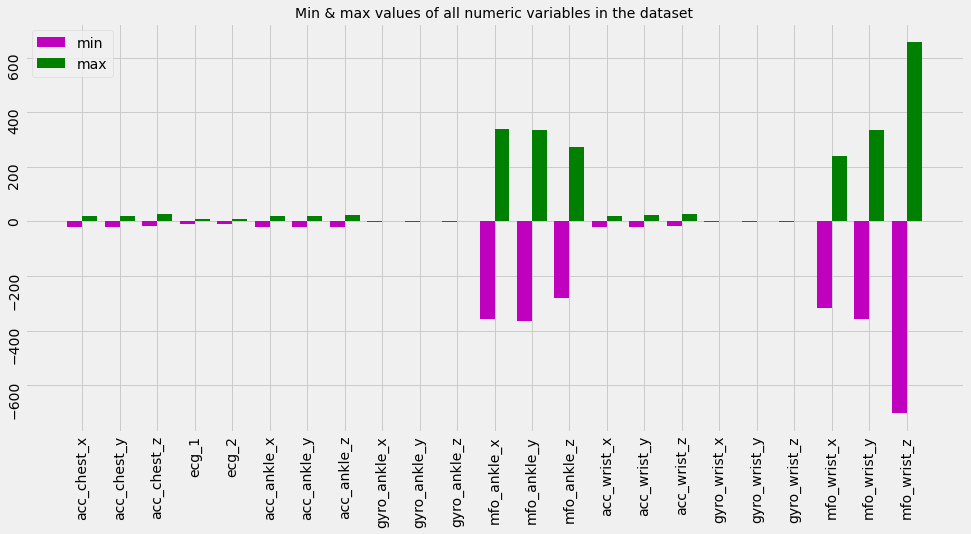

In [308]:
with plt.style.context('fivethirtyeight'):
    fig,ax = plt.subplots(figsize=(15,7))

    x = np.arange(len(descriptive_stats.columns))
    width = 0.4
    
    ax.bar(x - width/2, height=descriptive_stats.loc['min'], width=width, align='center', color='m')
    ax.bar(x + width/2, height=descriptive_stats.loc['max'], width=width, align='center', color='g')
    ax.set_xticks(x)
    ax.set_xticklabels(descriptive_stats.columns)
    ax.tick_params(labelrotation=90, labelsize=14)
    ax.set_title('Min & max values of all numeric variables in the dataset', fontsize=14)
    ax.legend(['min','max'])

    plt.show()

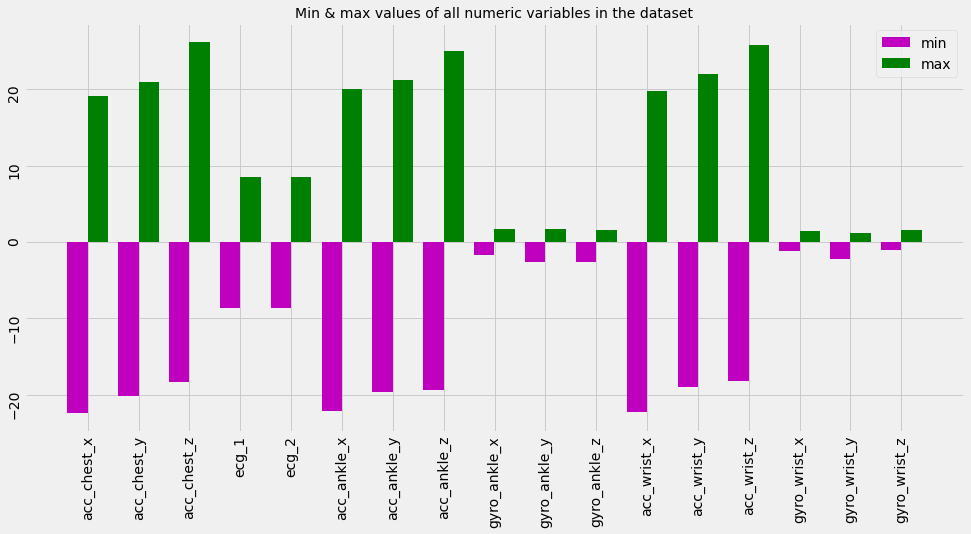

In [309]:
# Filter out magnetic field orientation variables as they fall onto much higher scale
descriptive_stats = descriptive_stats.filter(regex='^[^(mfo)]',axis=1)

with plt.style.context('fivethirtyeight'):
    fig,ax = plt.subplots(figsize=(15,7))

    x = np.arange(len(descriptive_stats.columns))
    width = 0.4
    
    ax.bar(x - width/2, height=descriptive_stats.loc['min'], width=width, align='center', color='m')
    ax.bar(x + width/2, height=descriptive_stats.loc['max'], width=width, align='center', color='g')
    ax.set_xticks(x)
    ax.set_xticklabels(descriptive_stats.columns)
    ax.tick_params(labelrotation=90, labelsize=14)
    ax.set_title('Min & max values of all numeric variables in the dataset', fontsize=14)
    ax.legend(['min','max'])

    plt.show()

As can be seen, the groups of variables fall into very differrent ranges. We have to keep this in mind for the learning stage, as some machine learning algorithms expect data that is standardized.

In [233]:
# Create mask for variables of type float only
float_mask = (all_subjects.dtypes == float)

### Variable distribution
First, let's plot the global distribution of all numeric variables over all subjects and activities.

In [310]:
# For plotting, convert labels to their string representations
plot_frame = all_subjects.copy()
plot_frame['activity'] = all_subjects['activity'].apply(lambda x: map_activity(x))

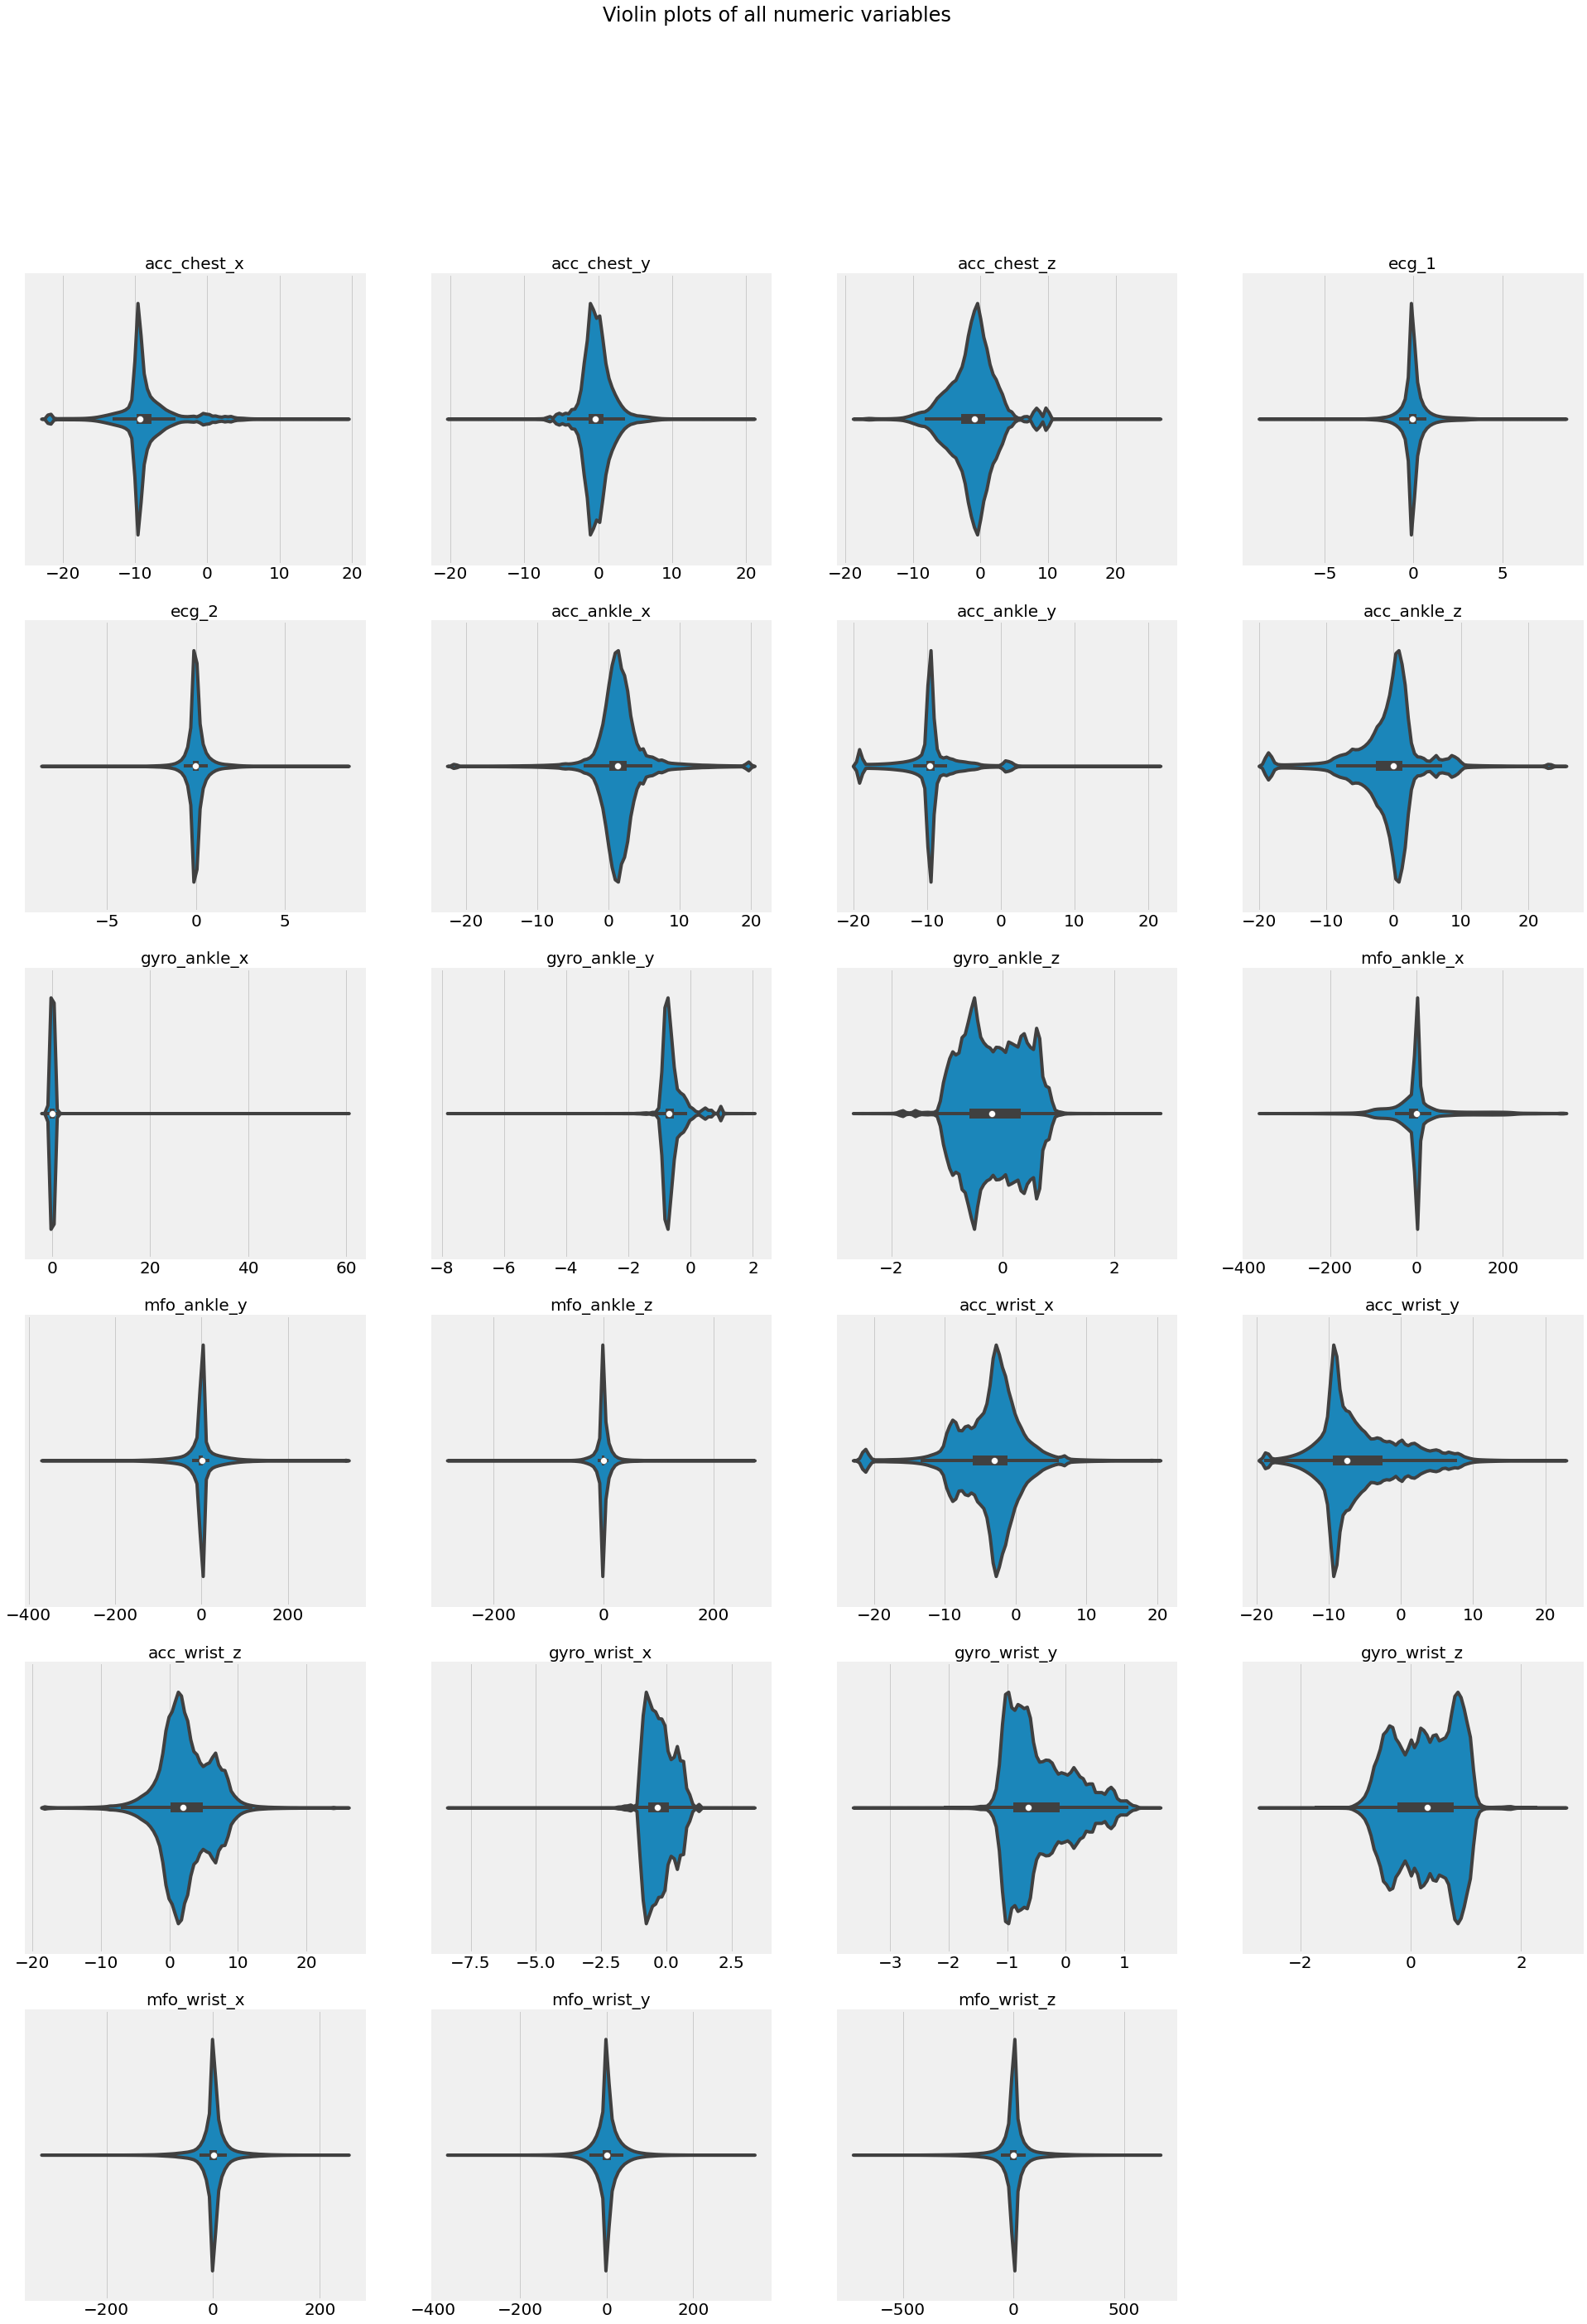

In [234]:
fig = plt.figure(figsize=(30,45))
for ix,col in enumerate(plot_frame.columns[float_mask],1):
    ax = fig.add_subplot(6,4,ix)
    sns.violinplot(plot_frame[col], scale='count', inner='box', kde=True,ax=ax)
    ax.tick_params(labelsize=20)
    ax.set_title(col, fontsize=24)
    ax.xaxis.get_label().set_visible(False)

fig.suptitle('Violin plots of all numeric variables', fontsize=24)
# fig.subplots_adjust(hspace = 0.3)
# plt.tight_layout()
fig.show()

What can we say about the distribution of the variables? 

Acceleration and turn rates have a multimodal distribution, meaning they have more than one peak. But while for acceleration there is still one peak clearly standing out, the distribution of turn rate is more scattered. ECG and MFO look normally distributed, but with long tails.

For acceleration, we can see that for acc_chest_x, acc_wrist_y and acc_ankle_y, the peak of their distributions are around -10. Since accelerometers are influenced by gravity, these are most likely the directions towards wich gravity is pulling the sensors. 

Let's see the distribution of variables over all different activities that are executed. This can be better visualized with boxplots.

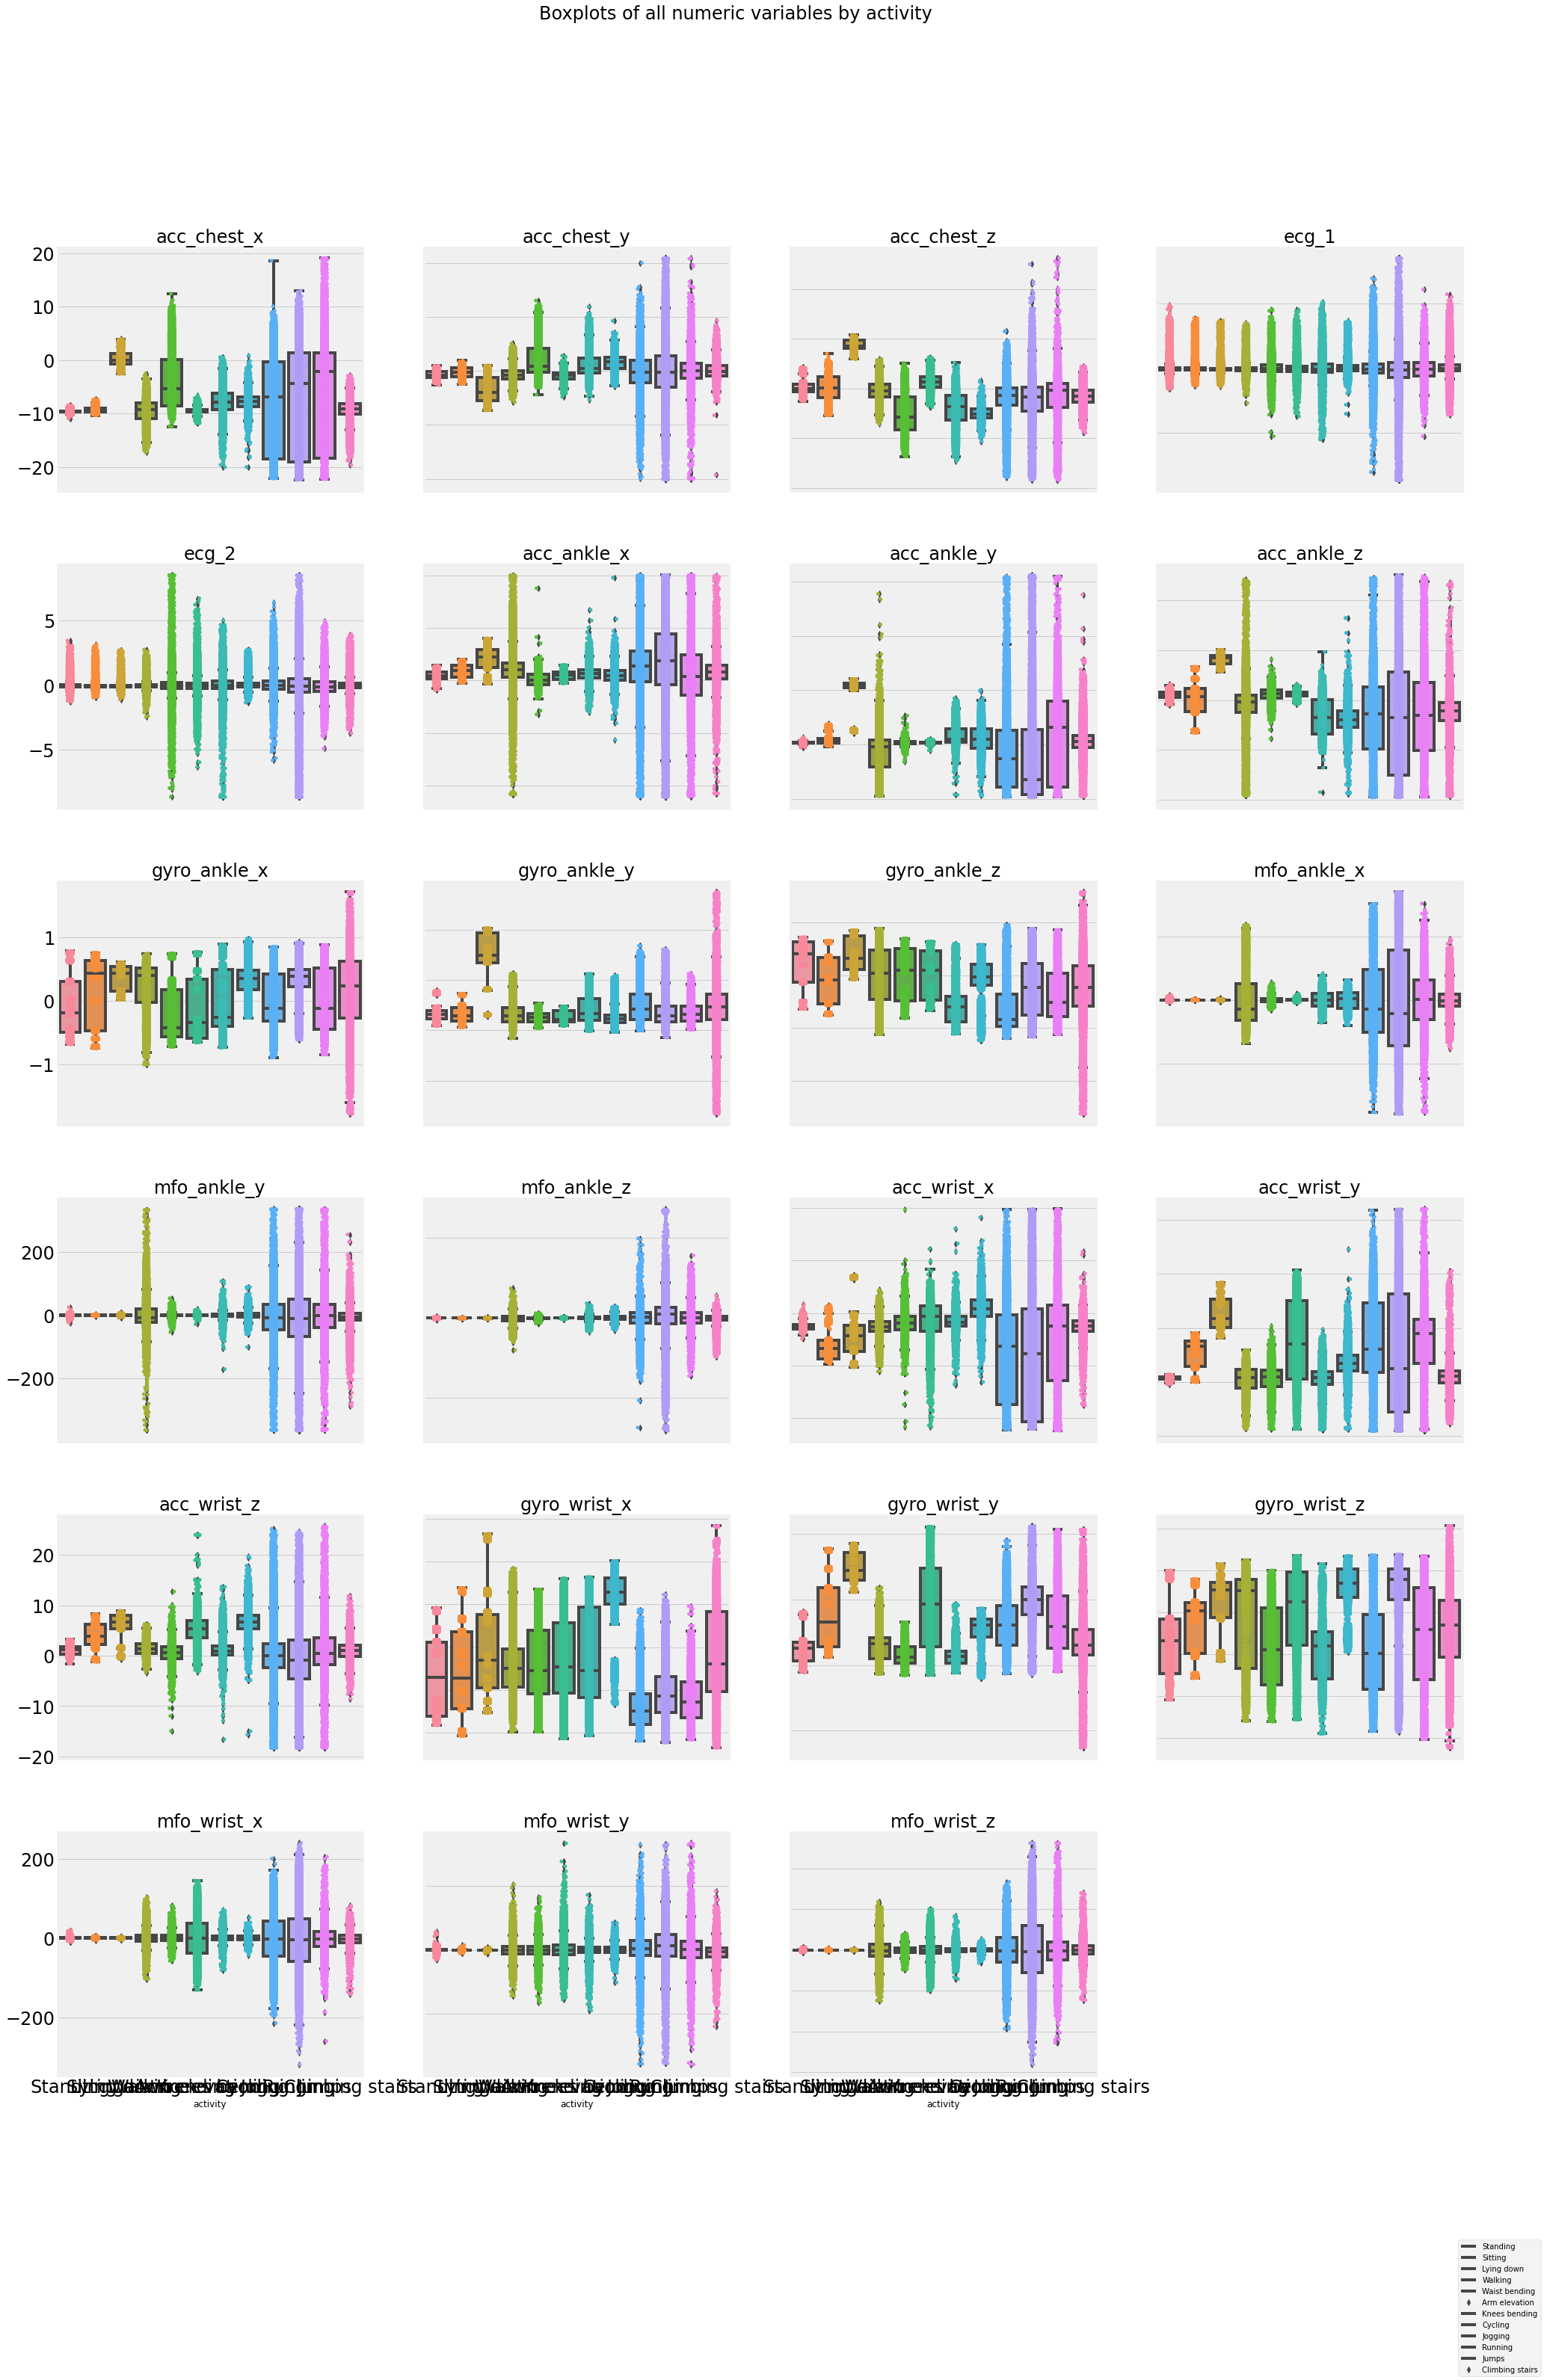

In [312]:
fig = plt.figure(figsize=(30,45))
for ix,col in enumerate(plot_frame.columns[float_mask],1):
    ax = fig.add_subplot(6,4,ix)
    sns.boxplot(data=plot_frame, x='activity', y=col, ax=ax)
    sns.stripplot(x='activity', y=col, data=plot_frame, ax=ax, jitter=True)
    ax.set_title(col, fontsize=24)
    ax.yaxis.get_label().set_visible(False)
    ax.tick_params(labelsize=24)

# for ax in fig.axes:
    ax.label_outer()

fig.legend(plot_frame.activity.unique(), loc='lower right')
fig.suptitle('Boxplots of all numeric variables by activity', fontsize=24)
fig.subplots_adjust(hspace = 0.3)
# plt.tight_layout()
fig.show()

# What about share_y?


Most variables generally show a wider value range for activities that are more physically intense. Conversely, less physically intense activities show narrower ranges.

The exception are measurements captured by the gyroscopes which measure turn rate. Climbing stairs activates both the accelerometers and gyroscope sensors on the ankle and wrist quite much. 

The magnetic field orientation reacts to movement. Both ankle and wrist sensors do not signal activity in situations in which body parts are (mainly) still (1 to 3). For frontal arm elevation, the wrist sensor signals more activity, whereas in situations with more involvement of the feet (such as climbing stairs), ankle sensors show more activity.

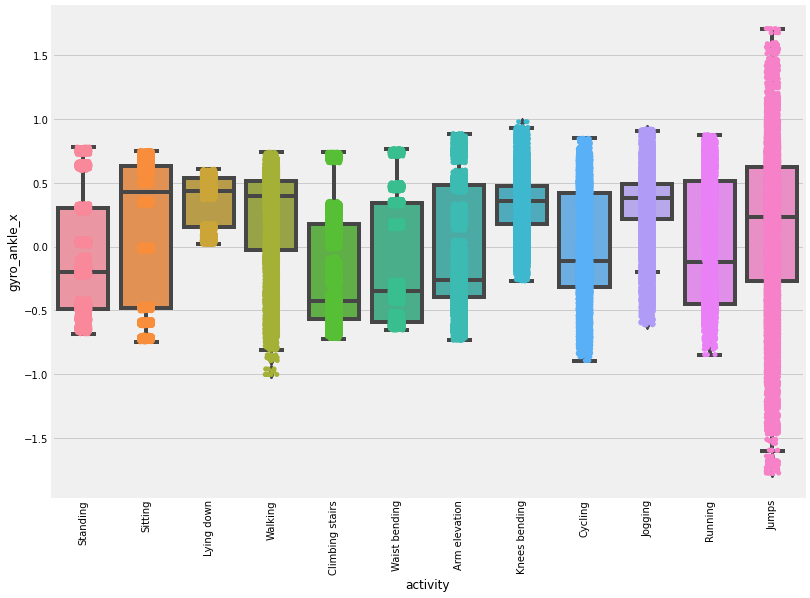

In [237]:
# We can also look at some variables in greater detail

fig,ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=plot_frame, x='activity', y='gyro_ankle_x')
sns.stripplot(x='activity', y='gyro_ankle_x', data=plot_frame, ax=ax, jitter=True)
ax.set_xticklabels(activities_index, rotation=90)
plt.show()

Violin plots are good to identify multimodal distributions, as we have seen for some of the variables in the dataset:

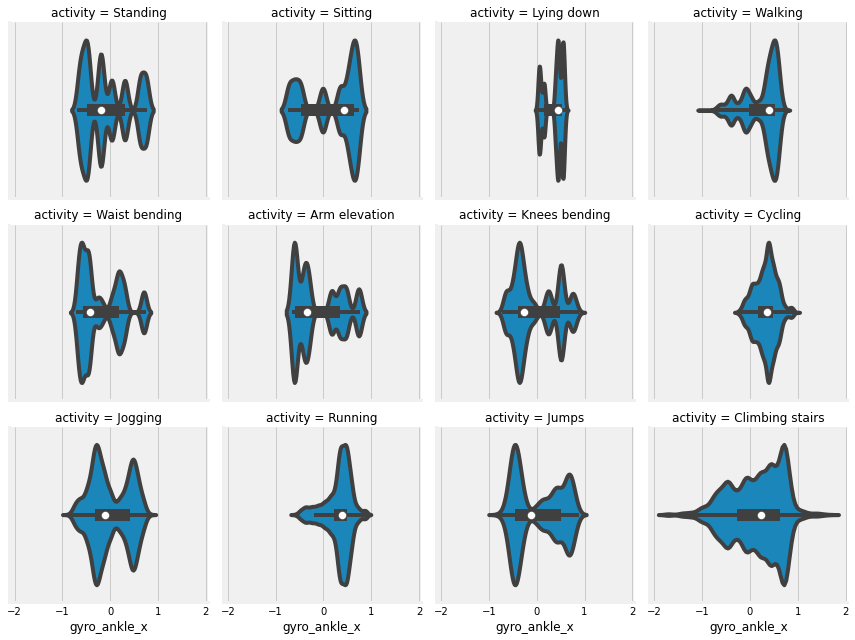

In [240]:
g = sns.FacetGrid(plot_frame, col="activity", col_wrap=4)
g.map(sns.violinplot, "gyro_ankle_x")
plt.show()

### Bivariate relationships

Exploring the relationship among several numeric variables, the first thing that pops into mind are correlations.

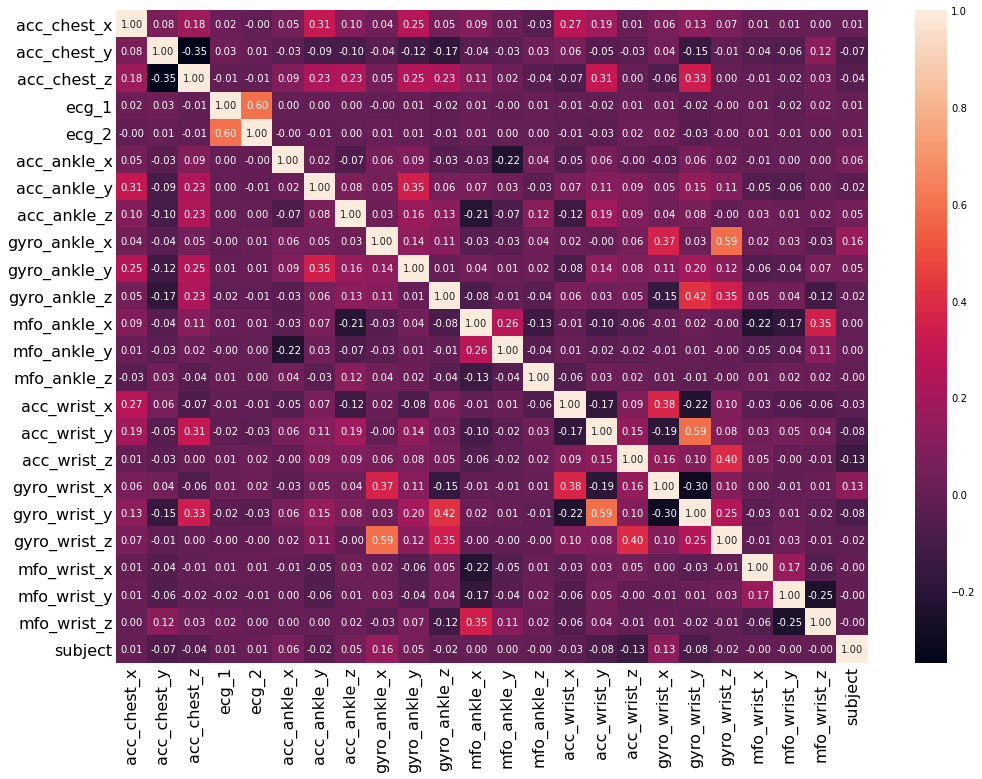

In [274]:
fig,ax = plt.subplots(figsize=(15,12))
sns.heatmap(plot_frame.corr(), annot=True, fmt='.2f')
ax.tick_params(labelsize=16)
plt.show()

We can observe correlations of medium strength between variables that measure the same thing at the same bodypart (e.g. *acc_chest_y & acc_chest_z* -> -0.41), the same thing at different bodyparts (*gyro_ankle_x & gyro_wrist_z* -> 0.60), different things at the same bodypart (*acc_ankle_y & gyro_ankle_y* -> 0.45) and between variables that measure different things at different bodyparts (*gyro_wrist_y & acc_chest_z* -> 0.49).

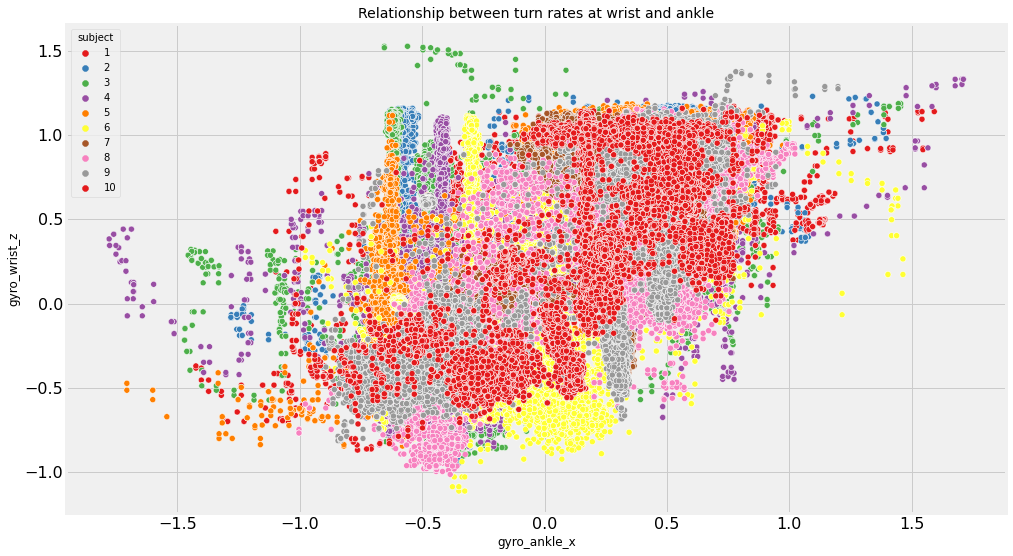

In [313]:
# Taking a visual look at the relationship between gyro_ankle_x & gyro_wrist_z (corr: 0.6)
fig,ax = plt.subplots(figsize=(15,9))
ax = sns.scatterplot(data=plot_frame, x='gyro_ankle_x', y='gyro_wrist_z', hue='subject', palette='Set1')
ax.set_title('Relationship between turn rates at wrist and ankle', fontsize=14)
ax.tick_params(labelsize=16)
plt.show()

One can see the general pattern of correlation. Some subjects like subject 4 have a wider range of values. This could point  to differences in movement patterns that exist between humans.

In [234]:
# Relationship between turn rates at wrist and ankle by subject 
def scatterplot_by_activity(var_1, var_2):
    sns.FacetGrid(plot_frame, col='activity', col_wrap=4)\
    .map(sns.scatterplot, var_1, var_2, s=100, alpha=.5, color='m')\
    .add_legend()
    plt.show()

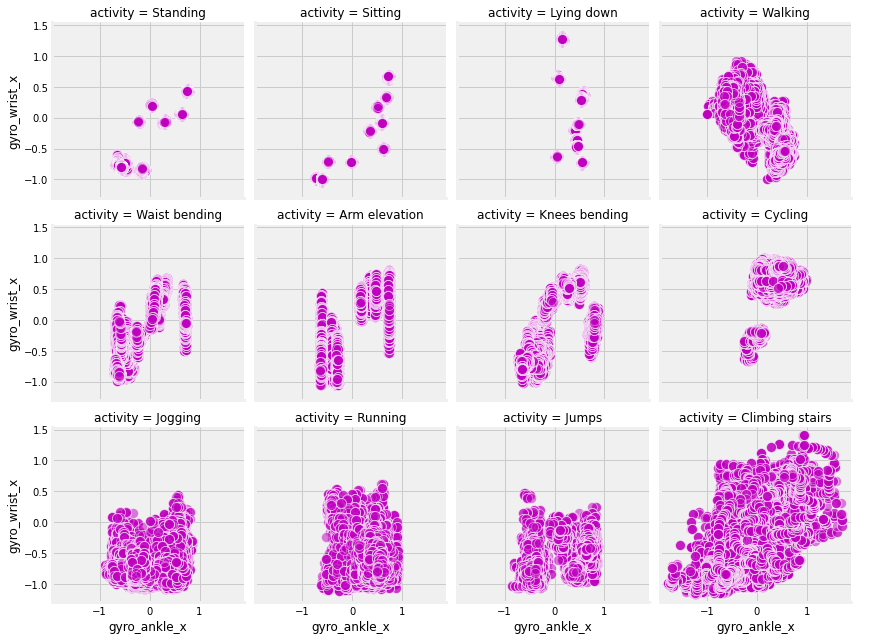

In [237]:
scatterplot_by_activity("gyro_ankle_x", "gyro_wrist_x")

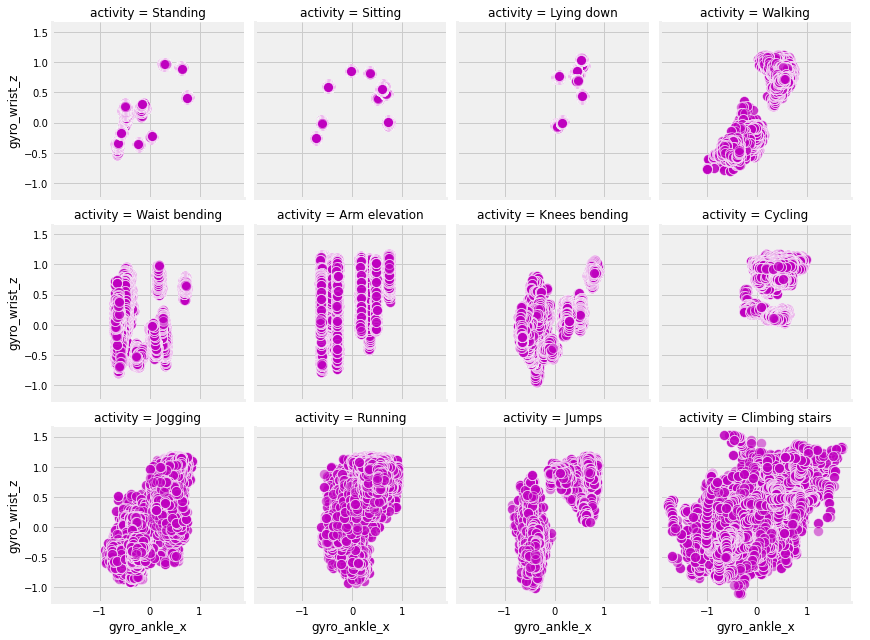

In [236]:
scatterplot_by_activity("gyro_ankle_x", "gyro_wrist_z")

The pattern of correlation does only occur for activities in which the ankle is actually moved.

# Measurements by subject

We can also contrast variables among the test subjects to see how they differ in their movement patterns

In [321]:
# For each subject, get the globaL mean values for each variable aggregated over all activities
global_by_subject = plot_frame.groupby('subject').mean()

# Additionally, for each subject get the mean values aggregated over each distinct activity 
activities_by_subject = plot_frame.groupby(['activity', 'subject']).mean()

In [323]:
activities_by_subject

acc_chest_x  acc_chest_y  acc_chest_z     ecg_1  \
activity      subject                                                    
Arm elevation 1          -9.365113     0.322587     2.840988 -0.024476   
              2          -9.345790    -0.431067     2.151525 -0.008288   
              3          -9.610268    -0.281101     1.201034 -0.019401   
              4          -9.632405    -0.862260     0.685871 -0.019290   
              5          -9.547632    -1.530438     0.815869  0.020755   
...                            ...          ...          ...       ...   
Walking       6          -9.696540    -0.569463    -0.767856 -0.168660   
              7          -9.592476    -1.205842    -1.363622 -0.038043   
              8          -9.393515    -1.351434     2.441683 -0.046623   
              9          -9.621965    -1.553226    -0.588499  0.015358   
              10         -9.396715    -0.391427    -2.405277 -0.003491   

                          ecg_2  acc_ankle_x  acc_ankle_y  acc_ankle_z  \
activity      subject                                                    
Arm elevation 1       -0.035386     2.339206    -9.522486     0.741312   
              2       -0.002347     0.346182    -9.636926     1.445619   
              3       -0.013499     0.082834    -9.685070     1.790318   
              4        0.013646    -0.064818    -9.723440     1.611559   
              5        0.100700     1.532070    -9.685312     0.469187   
...                         ...          ...          ...          ...   
Walking       6       -0.089359     3.020222   -11.257619     0.043455   
              7       -0.025120     1.627343   -10.983394    -0.613130   
              8       -0.029161     2.617918   -11.056214    -2.886388   
              9        0.008100     2.212419   -11.509684    -1.234109   
              10      -0.001086     1.489867   -11.079595    -1.396812   

                       gyro_ankle_x  gyro_ankle_y  ...  mfo_ankle_z  \
activity      subject                              ...                
Arm elevation 1           -0.352141     -0.803686  ...    -0.307547   
              2           -0.577476     -0.829998  ...    -0.093809   
              3           -0.616812     -0.818069  ...    -0.286554   
              4           -0.419392     -0.575131  ...    -0.132638   
              5           -0.624406     -0.771185  ...    -0.718176   
...                             ...           ...  ...          ...   
Walking       6           -0.059192     -0.711171  ...    -1.110504   
              7            0.257192     -0.694451  ...    -2.736957   
              8           -0.497332     -0.677299  ...    -1.565720   
              9            0.544946     -0.649980  ...    -3.963023   
              10           0.504237     -0.675988  ...    -0.762114   

                       acc_wrist_x  acc_wrist_y  acc_wrist_z  gyro_wrist_x  \
activity      subject                                                        
Arm elevation 1          -3.625266    -2.276008     4.549780     -0.660950   
              2           0.051956    -2.129737     6.837429     -0.438346   
              3           0.854059    -2.207975     5.167730     -0.200439   
              4           1.450814    -3.988853     4.339913     -0.374576   
              5          -2.451940    -3.760447     3.536252     -0.692098   
...                            ...          ...          ...           ...   
Walking       6          -4.043120    -9.187004     1.866207      0.108890   
              7          -1.679992    -9.170019     3.163189     -0.209385   
              8          -2.886927    -9.567369    -0.116125      0.118995   
              9          -3.103902    -9.321488     1.066322     -0.443346   
              10         -3.080065    -9.283996     0.537380     -0.639683   

                       gyro_wrist_y  gyro_wrist_z  mfo_wrist_x  mfo_wrist_y  \
activity      subject                                                         


Now, we can plot stats by subject globally over all activities and separated by activity.

In [341]:
# Let's define a function that plots the means of variables globally over all activities by subject
def plot_global_mean_by_subject(attributes):
    fig,ax = plt.subplots(figsize=(12,7.6))
    global_by_subject.groupby('subject').mean()[attributes].plot.bar(ax=ax)
    ax.set_title(f'Mean values for {" & ".join(attributes)}')
    ax.set_xticks(np.arange(plot_frame.subject.nunique()))
    ax.legend(loc=1)
    plt.show()
    
# Let's define a function that plots the means of variables for each activitity by subject
def plot_means_by_subject_and_activity(attributes):
    fig = plt.figure(figsize=(30,30))
    for ix,a in enumerate(activites_index,1):
        ax = fig.add_subplot(4,3,ix)
        activities_by_subject.loc[a][attributes].plot(ax=ax)
        ax.set_title(a, fontsize=24)
        ax.set_xticks(np.arange(plot_frame.subject.nunique()))
        ax.tick_params(labelsize=20)
        ax.set_xlabel([])
        ax.get_legend().remove()
        
    fig.legend(attributes, loc='upper right', fontsize=24)
    fig.suptitle(f'Mean values across all activities and subjects for variables {" ".join(attributes)}', fontsize=28)
    plt.show()

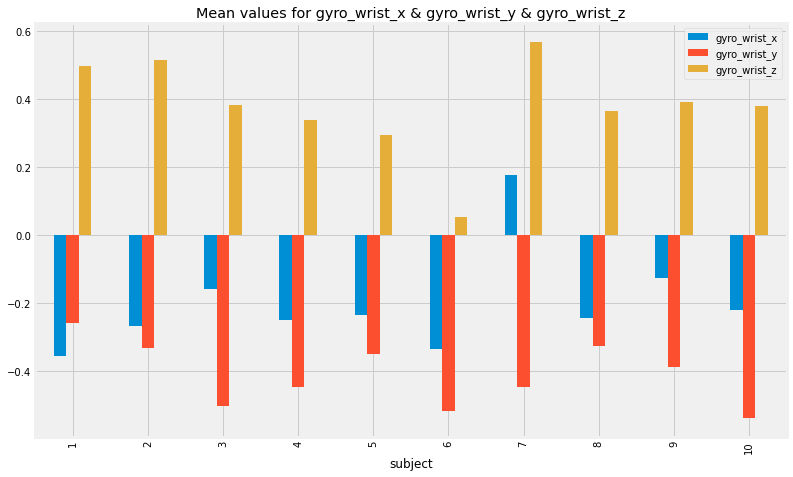

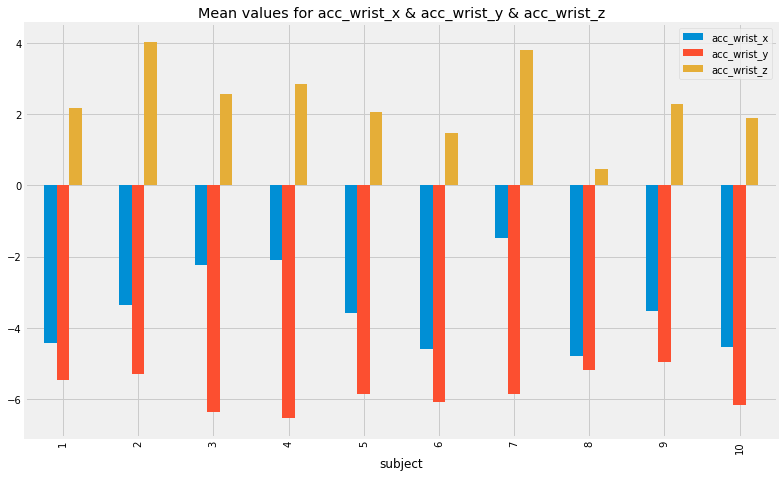

In [327]:
plot_global_mean_by_subject(['gyro_wrist_x', 'gyro_wrist_y', 'gyro_wrist_z'])
plot_global_mean_by_subject(['acc_wrist_x', 'acc_wrist_y', 'acc_wrist_z'])

 => Quite some differences based on the averages of said values

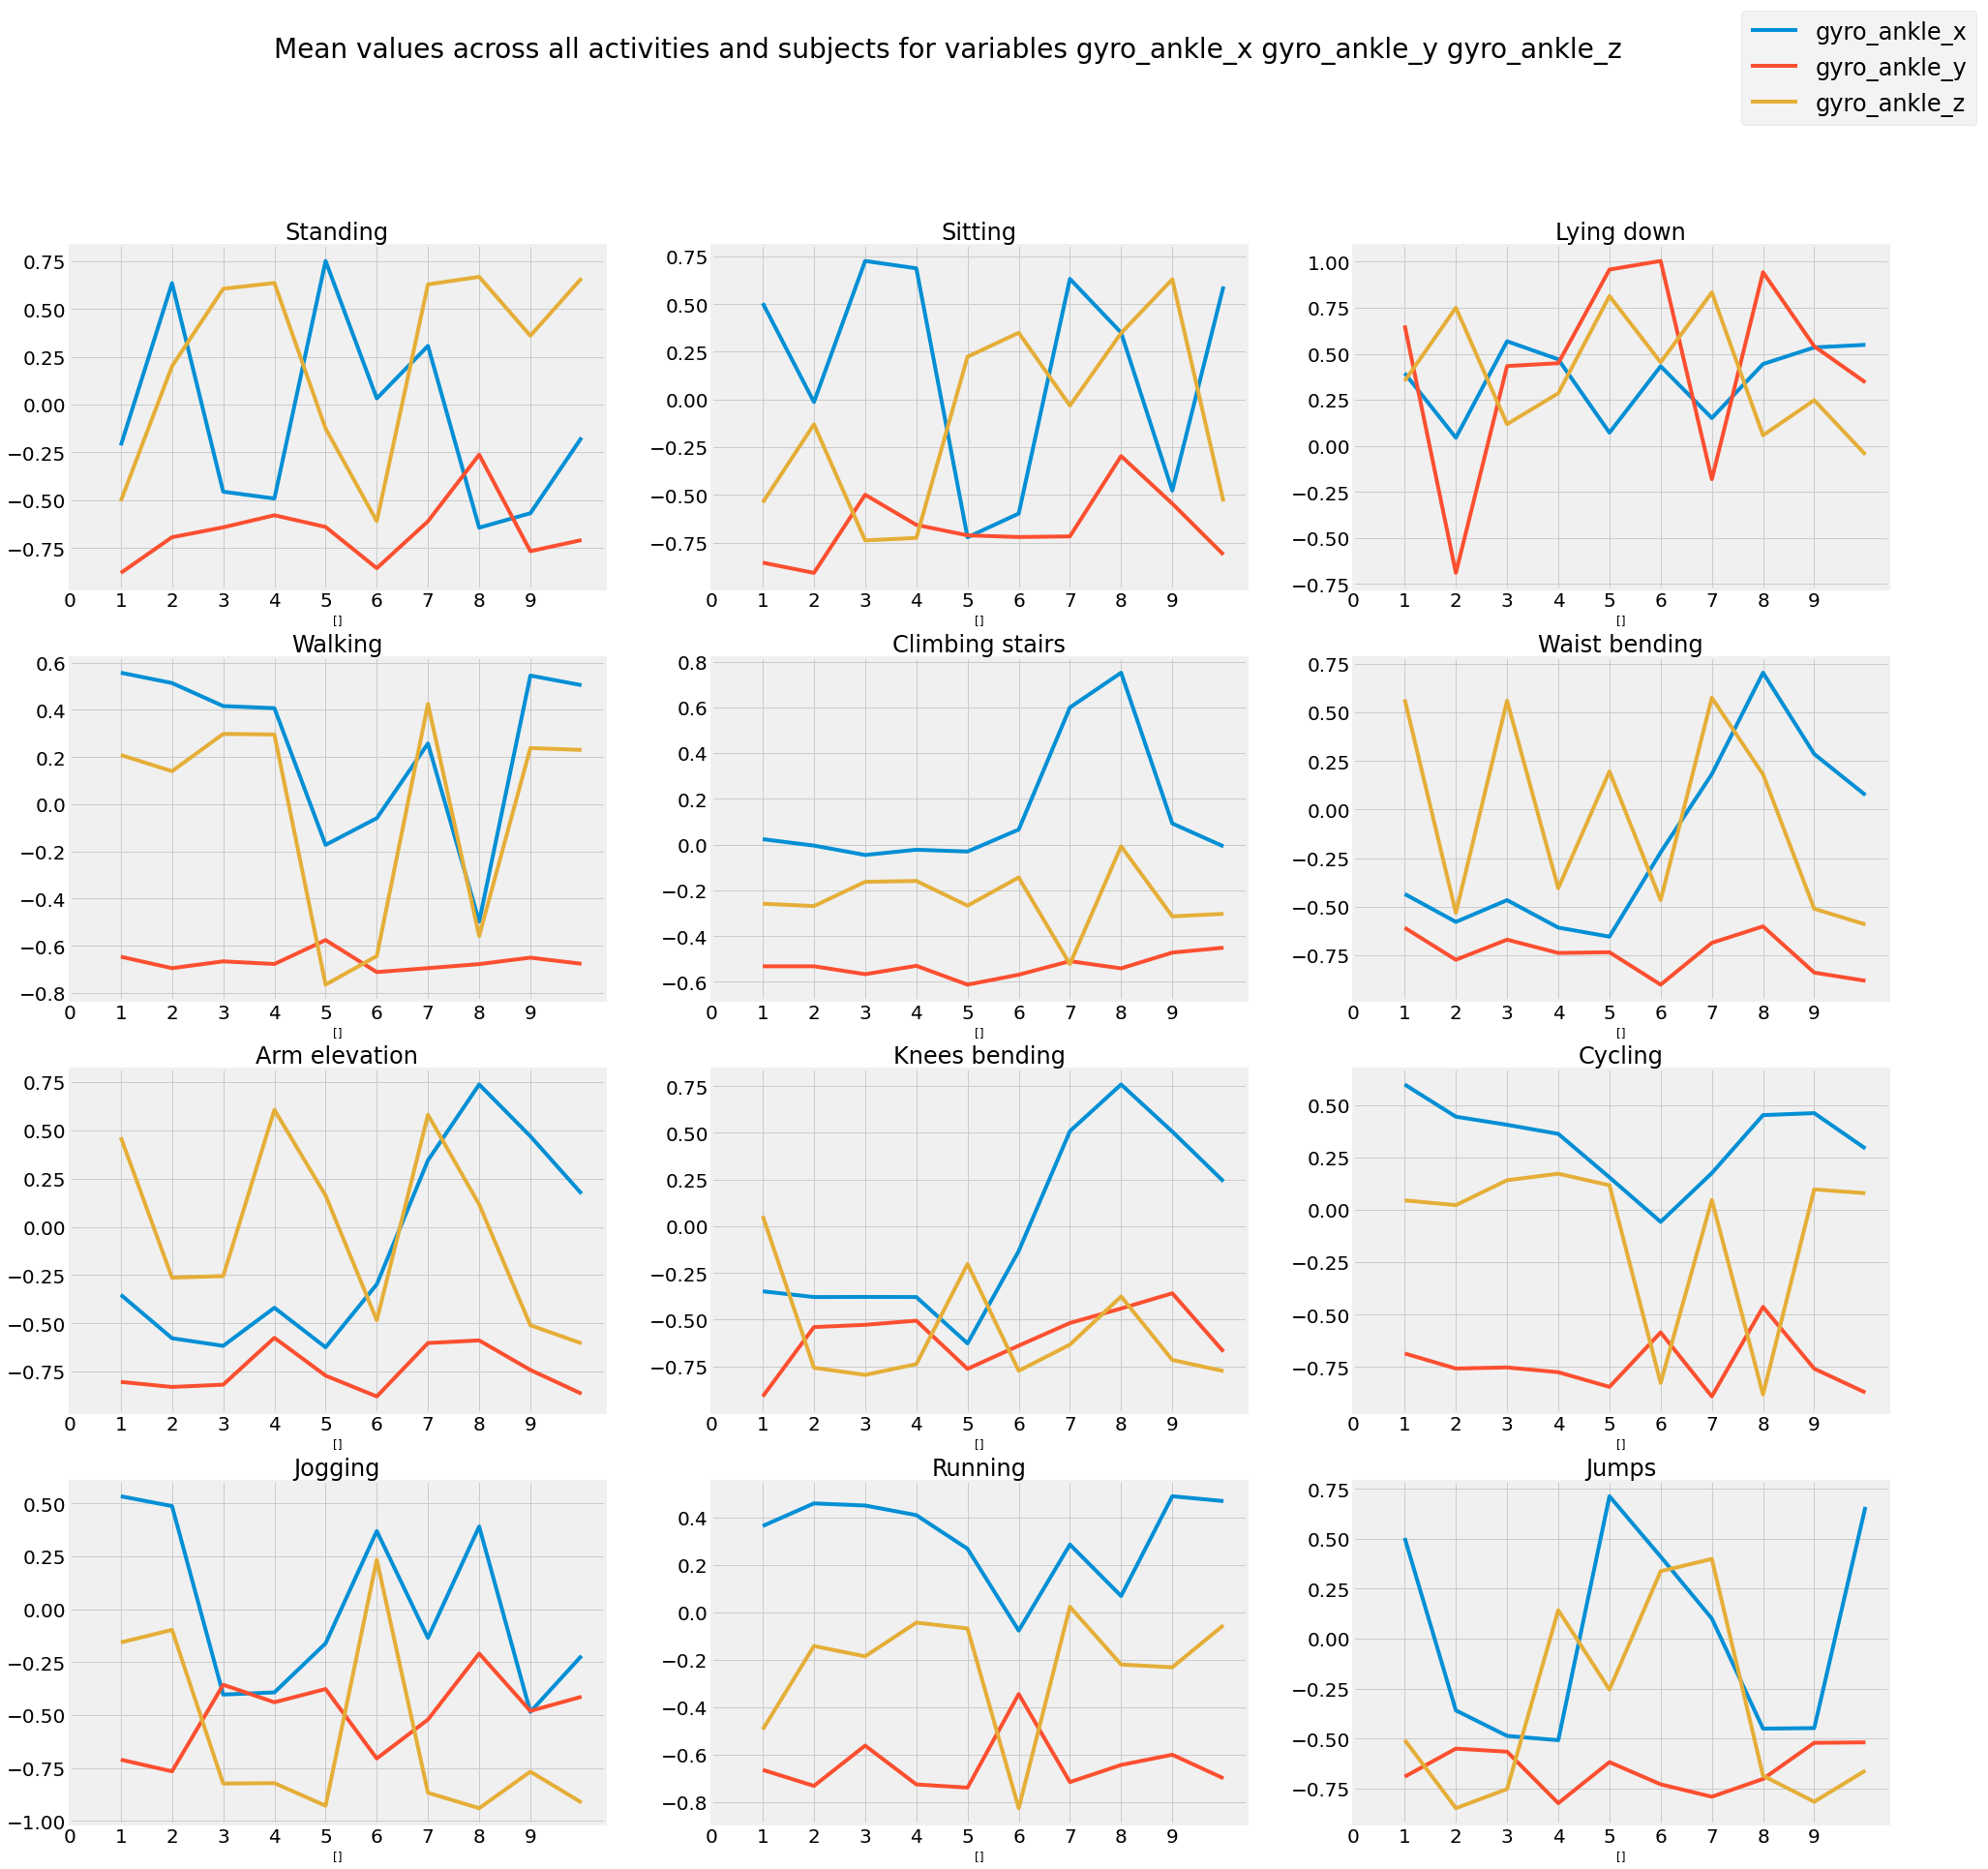

In [342]:
plot_means_by_subject_and_activity(['gyro_ankle_x','gyro_ankle_y', 'gyro_ankle_z'])

For some people, a point plot might be easier on the eyes. The following plot shows the same information as above, but with a separate line for each subject that denotes the mean value of a given variable across all activities.

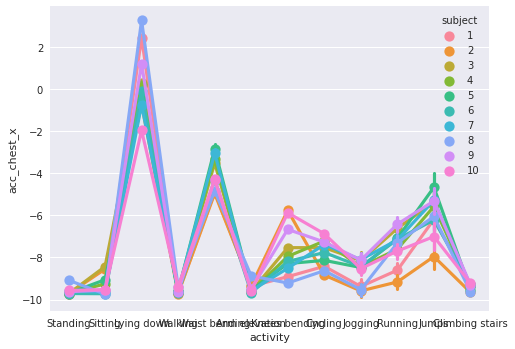

In [344]:
# Taking a look at relationship between turn rates at wrist and ankle
with plt.style.context('seaborn'):
    fig,ax = plt.subplots(figsize=(7,5.6))
    sns.pointplot(data=plot_frame, x='activity', y='acc_chest_x', hue='subject', dodge=False, linewidth=0.2,ax=ax)
    fig.show()

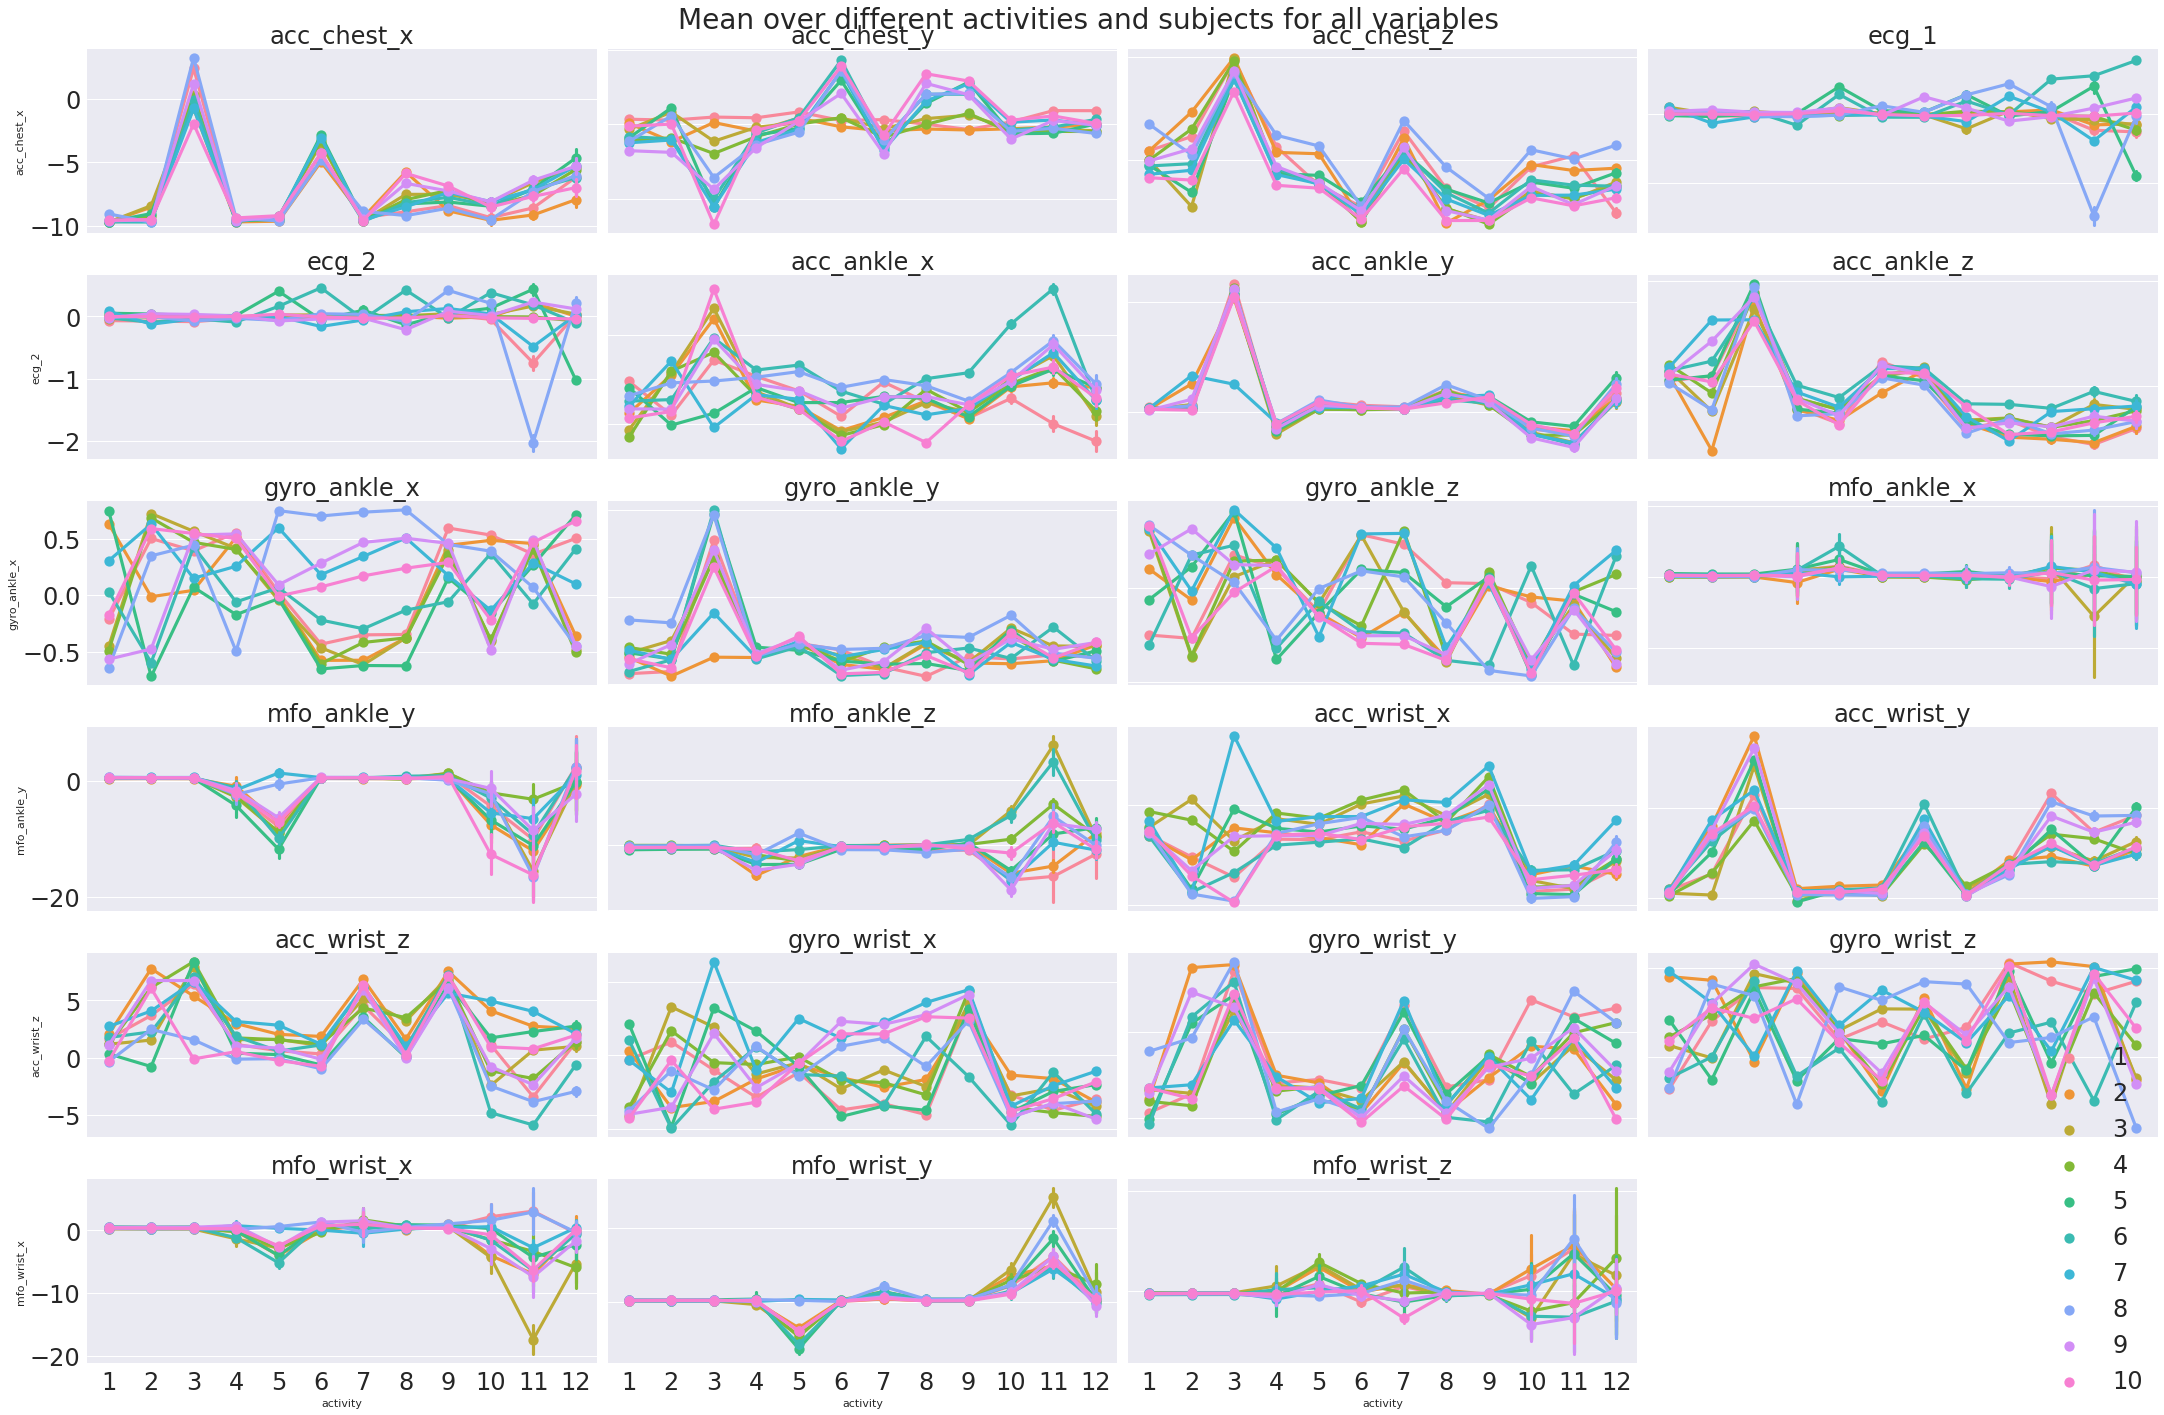

In [345]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(30,20))
    for ix,col in enumerate(all_subjects.columns[float_mask],1):
        ax = fig.add_subplot(6,4,ix)
        sns.pointplot(data=all_subjects, x='activity', y=col, hue='subject', ax=ax)
        ax.set_title(col, fontsize=24)
        ax.tick_params(labelsize=24)
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    fig.legend(handles, labels, loc='lower right', fontsize=24)
#         ax.get_xaxis().set_visible(False)
    #     plt.clf()
    
    for ax in fig.get_axes():
        ax.label_outer()
#     ax.get_xaxis().set_visible(False)
#     fig.legend(all_subjects.subject.unique(), loc='upper right', fontsize=24)
    fig.suptitle(f'Mean over different activities and subjects for all variables', fontsize=28)
    fig.subplots_adjust(hspace=0.3, top=0.95)
    plt.tight_layout()
    fig.show()

In this plot, you can see for which variables subjects vary the most from each other. Gyroscope values are more subject-specific, whereas for other variables the curves follow a more similar pattern across subjects. These insights are important in deciding whether for a classification task, one can train an aggregate model for predicting the movement of all subjects, or one should train subject-specific models.

### Visualize the measurement sequences of the individual test subjects. 

The measurements taken for each activity and subject can be regarded as a time series. 50 datapoints are collected per second from each sensor. All activities performed by a subject for 1 min thus should comprise of 3000 datapoints. We can plot these kinds of time series as well.

We plot the moving average over 200 instances.

In [362]:
default_figsize = plt.rcParams.get('figure.figsize')
def plot_test_series(subject_number, activity, var, moving_average=False, figsize=default_figsize):
        sub_frame = all_subjects[(all_subjects.subject == subject_number ) & (all_subjects.activity == activity )].reset_index()[var]
        title = f'Measurements of variable {var} for subject {subject_number}\n while {map_activity(activity)}'
        if moving_average:
            ax = sub_frame.rolling(window=50, min_periods=None).mean().plot(linewidth=1, figsize=figsize, title=title)
        else:
            ax = sub_frame.plot(linewidth=1, figsize=figsize, title=title)
        return ax
            

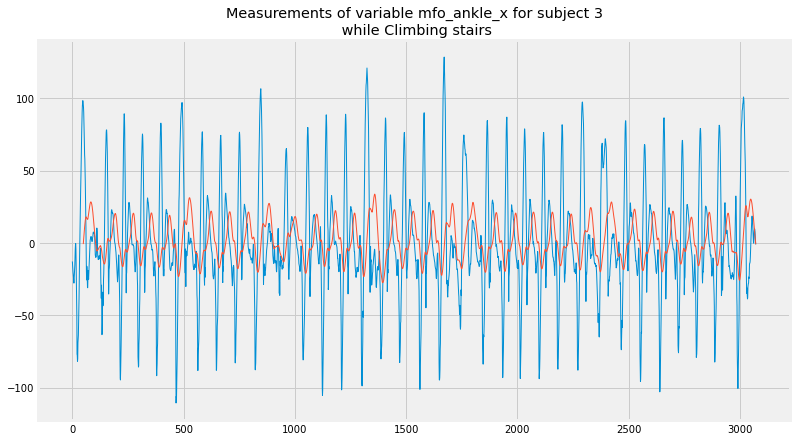

In [364]:
plot_test_series(3,5, 'mfo_ankle_x')
plot_test_series(3,5, 'mfo_ankle_x', moving_average=True, figsize=(12,7))
plt.show()

In this plot one can see how the moving average smoothes the time series  

By executing the function repeatedly, it is possible to plot multiple time series onto the same plot.

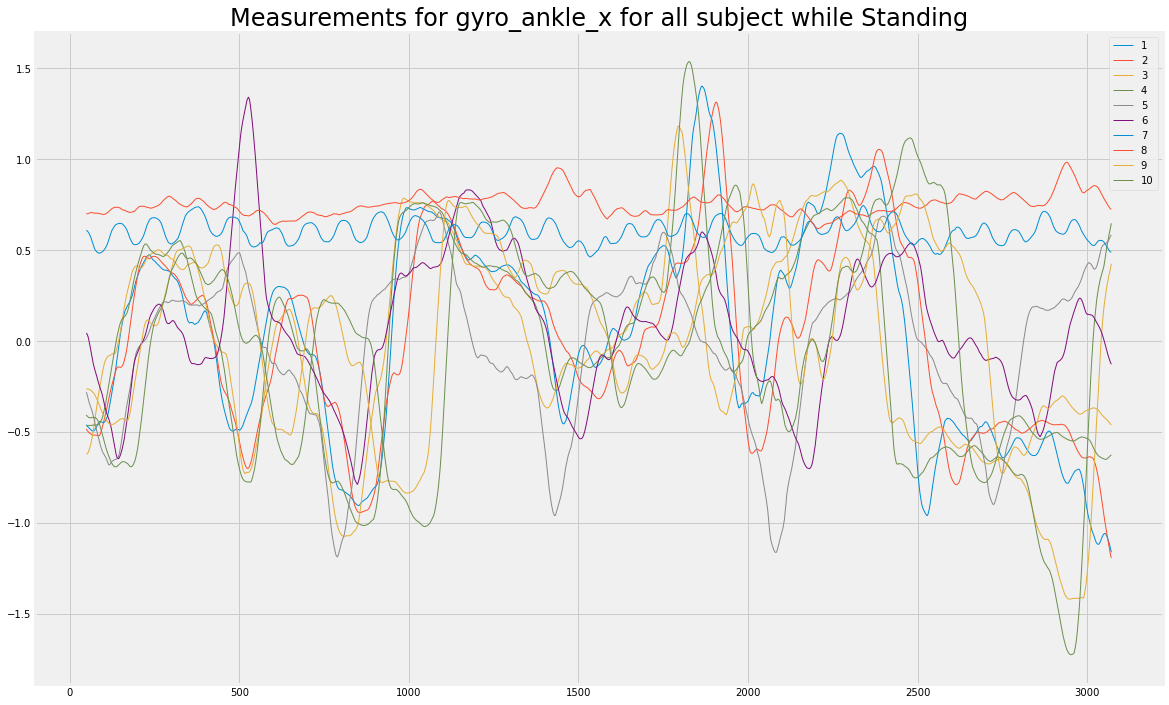

In [370]:
# Plot the same variable for all subjects for one specific activity into same plot
for i in range(1,11):
    plot_test_series(i,5, 'gyro_ankle_x', figsize=(18,12), moving_average=True)
    plt.title(f'Measurements for gyro_ankle_x for all subject while {map_activity(1)}', fontsize=24)
    plt.legend(all_subjects.subject.unique())

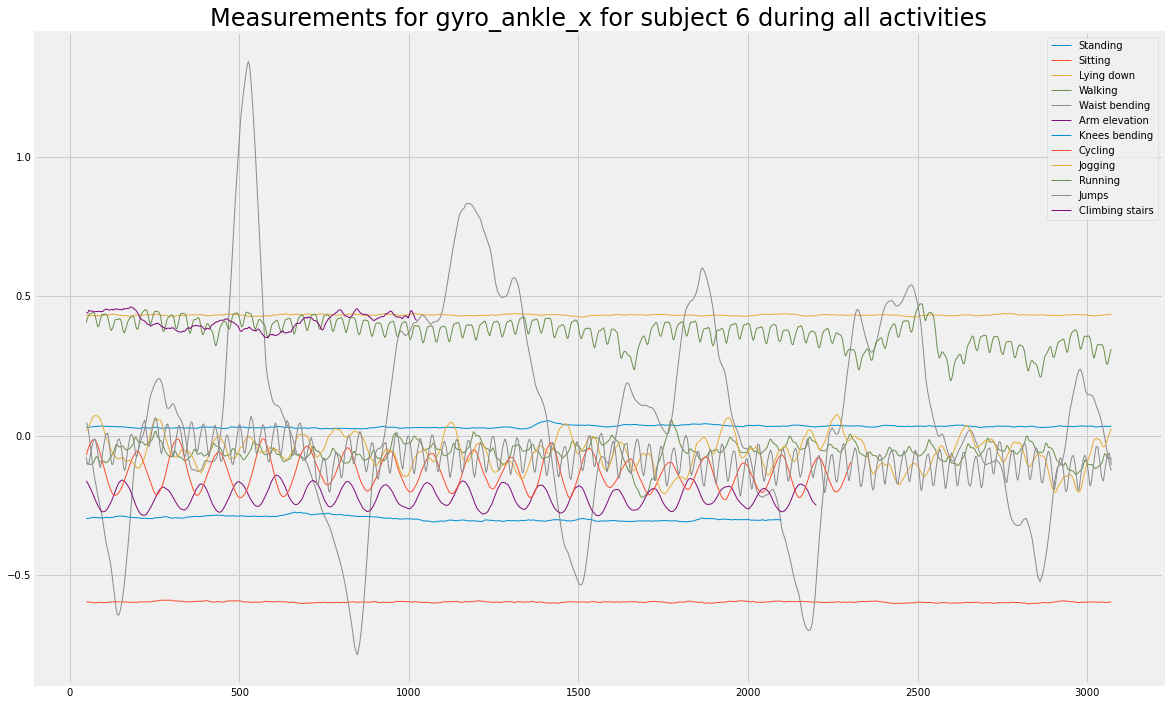

In [371]:
# Plot the time series of one variable for one specific subject over all different activities into same plot
for i in range(1,13):
    plot_test_series(6,i, 'gyro_ankle_x', figsize=(18,12), moving_average=True)
    plt.title(f'Measurements for gyro_ankle_x for subject 6 during all activities', fontsize=24)
    plt.legend([map_activity(a) for a in all_subjects.activity.unique()])

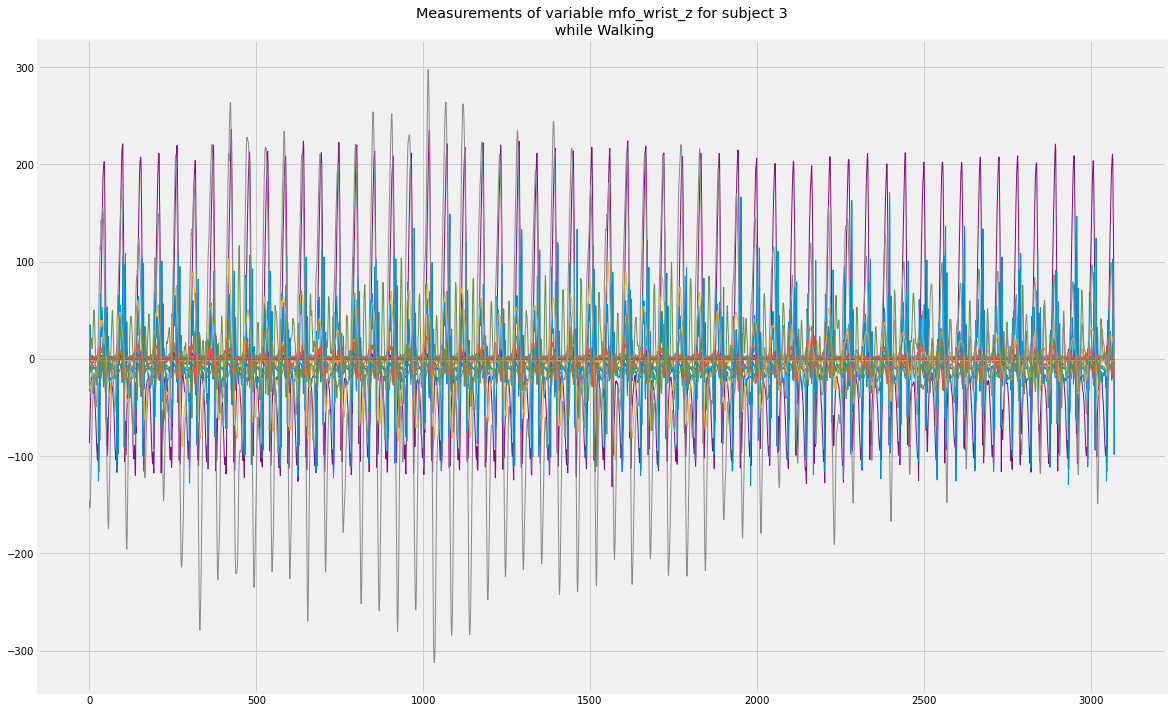

In [372]:
# Plot the time series of one specific subject and one specific activity over all variables 
for var in plot_frame.select_dtypes(float).columns:
    plot_test_series(3,4, var, figsize=(18,12))

This was just an excerpt of some ways to visualize the data with matplotlib and seaborn. Since there are 2 levels in the data with 10 (subject) respectively 12 (activity) distinct values, and 23 continous variables, there are a lot of ways to show the patterns in the data graphically. Covering all of it would inflate the scope of this notebook.

# Modelling part 

Now, let's get to the modelling part. Our goal here is to train a machine learning model that accurately predicts the physical activity a subject is performing given the body sensing data that is fed as input.

For model selection, as usual we will split the data into a train, validation and test set. The train and validation set will be used to cross-validate the models and to perform hyperparameter tuning. The test set is used to obtain the a prediction on data the models have not seen during the training process.

We have data from ten subjects available. Thinking from a business standpoint, we want to train a model that is able to classify data from physical activities of unseen subjects. Hence, we will apply the leave-one-group-out (LOGO) cross-validation scheme in which we train a model with the data of 9 different subjects and subsequently test it on data from an unseen subject. The question now is the data from which subejct do we want to use as test set? It might be best to use the most "average" subject as the  test set, with average relating to the classification performance. In a pre-test, I trained a logistic regression on the data that included all subjects, so each subject was tested against once in the LOGO scheme. This way, I was able to identify how well the models were performing on predicting the movements of each subject. As it turned out, subject 4 had the 5th best classifcation performance according to weighted F1 and is thus selected as the test set.

With the remaining data pertaining to the other nine subjects, we will train and score our model also by applying the LOGO scheme. Since we got nine subjects remaining, we will perform 9 different runs - in each run, we use data from 8 subjects to train the model and the data pertaining to the hold-out subject to validate the model. The train scores will then be averaged across runs for the final training error.

## Put data into windows
How can we improve on this performance? One approach is to put consecutive datapoints into non-overlapping windows, like it has done in the original mHealth paper. 

In [27]:
# As additional information for each window, we store the mean, std, max and min values of each existing variable
new_columns = []
for col in all_subjects.columns[float_mask]:
    new_columns.extend([f'{col}_mean', f'{col}_std', f'{col}_max', f'{col}_min'])
new_columns.extend(['subject', 'activity'])

Step size is set to 200 and we loop through each subject's data separately. In case a new activity is performed before the step size threshold is reached, then we need to start a new block, so that each block is only linked to one activity.

In [58]:
STEP_SIZE = 200
def read_into_blocks(subject_number):
    df = all_subjects[all_subjects.subject == subject_number]
    sub_samples = []
    
    current_activity = df.iloc[0].activity
    cnt = 0
    for i in range(0, df.shape[0]):
        # Step size of 200 is reached
        if cnt >= STEP_SIZE:
            window = df.iloc[i-STEP_SIZE:i]   
        # A new activity is performed
        elif df.iloc[i].activity != current_activity:
            window = df.iloc[i-cnt:i]
        # End of data frame
        elif i == df.shape[0] - 1:
            window = df.iloc[i-cnt:]
        else:
            cnt += 1 
            continue
            
        assert window.activity.nunique() == 1
        # Store summary statistics of each block
        stats = window.select_dtypes(float).apply([np.mean, np.std, np.max, np.min], axis=0).unstack().values
        sub_samples.append(np.append(stats, [subject_number, current_activity]))
        cnt = 1
        current_activity = df.iloc[i].activity
        
    out_df = pd.DataFrame(sub_samples, columns=new_columns)
    out_df.activity = out_df.activity.astype(int)
    out_df.subject = out_df.subject.astype(int)
    
    return out_df

In [29]:
dfs = []
for i in range(1,11):
    df = read_into_blocks(i)
    dfs.append(df)
block_df = pd.concat(dfs)

In [30]:
print(block_df.shape)

(1790, 94)


In [127]:
all_subjects = block_df.copy()

Split data into train and test set - subject 5 will be the test set

In [128]:
train_set = all_subjects[all_subjects.subject != 4]
test_set = all_subjects[all_subjects.subject == 4]

In [129]:
target_train = train_set.activity
target_test = test_set.activity

groups_train = train_set.subject
groups_test = test_set.subject

# Drop label and grouping variables
train_set = train_set.select_dtypes(float)
test_set = test_set.select_dtypes(float)

In [130]:
# Leave-One-Group-Out classifier
logo = LeaveOneGroupOut()
logo.get_n_splits(train_set, target_train, groups_train)

9

### Testing algorithms

There are many algorithms that we could potentially try on the problem at hand. We will try the following:

- Logistic Regression
- SVM
- Ridge Classifier
- SGD (logistic regression version)
- XGBoost 
- Light GBM

In [153]:
# Function to get back the scores of LOGO validation

def get_scores(clf, features, target, groups):
    '''Validating each model under the LOGO scheme and return scores as well as confusion matrices'''
    
    train_scores = []
    conf_mats = []
    
    for train_index, test_index in tqdm(logo.split(features, target, groups)):
    
        X_train, X_val = features.iloc[train_index], features.iloc[test_index]
        y_train, y_val = target.iloc[train_index], target.iloc[test_index]
        
        clf.fit(X_train, y_train)
        preds_val = pipeline.predict(X_val)
        try:
            score_val = pipeline.predict_proba(X_val)
        except AttributeError: 
            score_val = pipeline.decision_function(X_val)
            
        f1_val = metrics.f1_score(y_val,preds_val, average='weighted')
        train_scores.append(f1_val)
        conf_mats.append(metrics.confusion_matrix(y_val, preds_val))
        
        # More detailed classification report for printing
        print(f'{class_report(y_true=y_val, y_pred=preds_val, y_score=score_val, average="macro")}')
        
    return train_scores, conf_mats


# Classification report that includes ROC-AUC score for multiple classes 
# https://stackoverflow.com/questions/39685740/calculate-sklearn-roc-auc-score-for-multi-class

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = metrics.precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(metrics.precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = metrics.roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = metrics.auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = metrics.roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = metrics.roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = metrics.auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = metrics.auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

### Logistic Regression

In [244]:
# Data needs to be scaled before applying logistic regression 
scaler = StandardScaler()
clf = LogisticRegression(random_state=42, solver='sag')
pipeline = make_pipeline(scaler, clf)

In [ ]:
logreg_scores = get_scores(pipeline, train_set, target_train, groups_train)

In [ ]:
print(f'Train score Logistic Regression: {np.mean(logreg_scores[0])} +- {np.std(logreg_scores[0])}')

# Fit on all data
pipeline.fit(train_set.select_dtypes(float), target_train)
test_preds = pipeline.predict(test_set)
print(f'Test score: {metrics.f1_score(target_test, test_preds, average="weighted")}')

=> Already a very good score simply by using logistic regression

### Confusion matrix

With the help of a confusion matrix, we get important insights into the mistakes our classifier is actually making for each class. Hence, let's define functions to plot this matrix - individually by test subject, and also globally across all test subjects.

In [59]:
# Create index of physical activities
activites_index = [map_activity(i+1) for i in range(12)]

def plot_confmat_by_subject(confmats):
    # Create figure on which to put one subplot per subject
    fig = plt.figure(figsize=(23,30))
    for i, mat in enumerate(confmats,1):
        plot_mat = pd.DataFrame(mat, index=activites_index, columns=activites_index)
        ax = fig.add_subplot(5,2,i)
        sns.heatmap(plot_mat, annot=True, fmt='.0f', ax=ax)
        if i < 4:
            ax.set_title(f'Confusion matrix for subject {i}:')
        else: 
            ax.set_title(f'Confusion matrix for subject {i+1}:')
        ax.tick_params(axis='x', labelrotation=75)
        plt.tight_layout()
    
    fig.show()

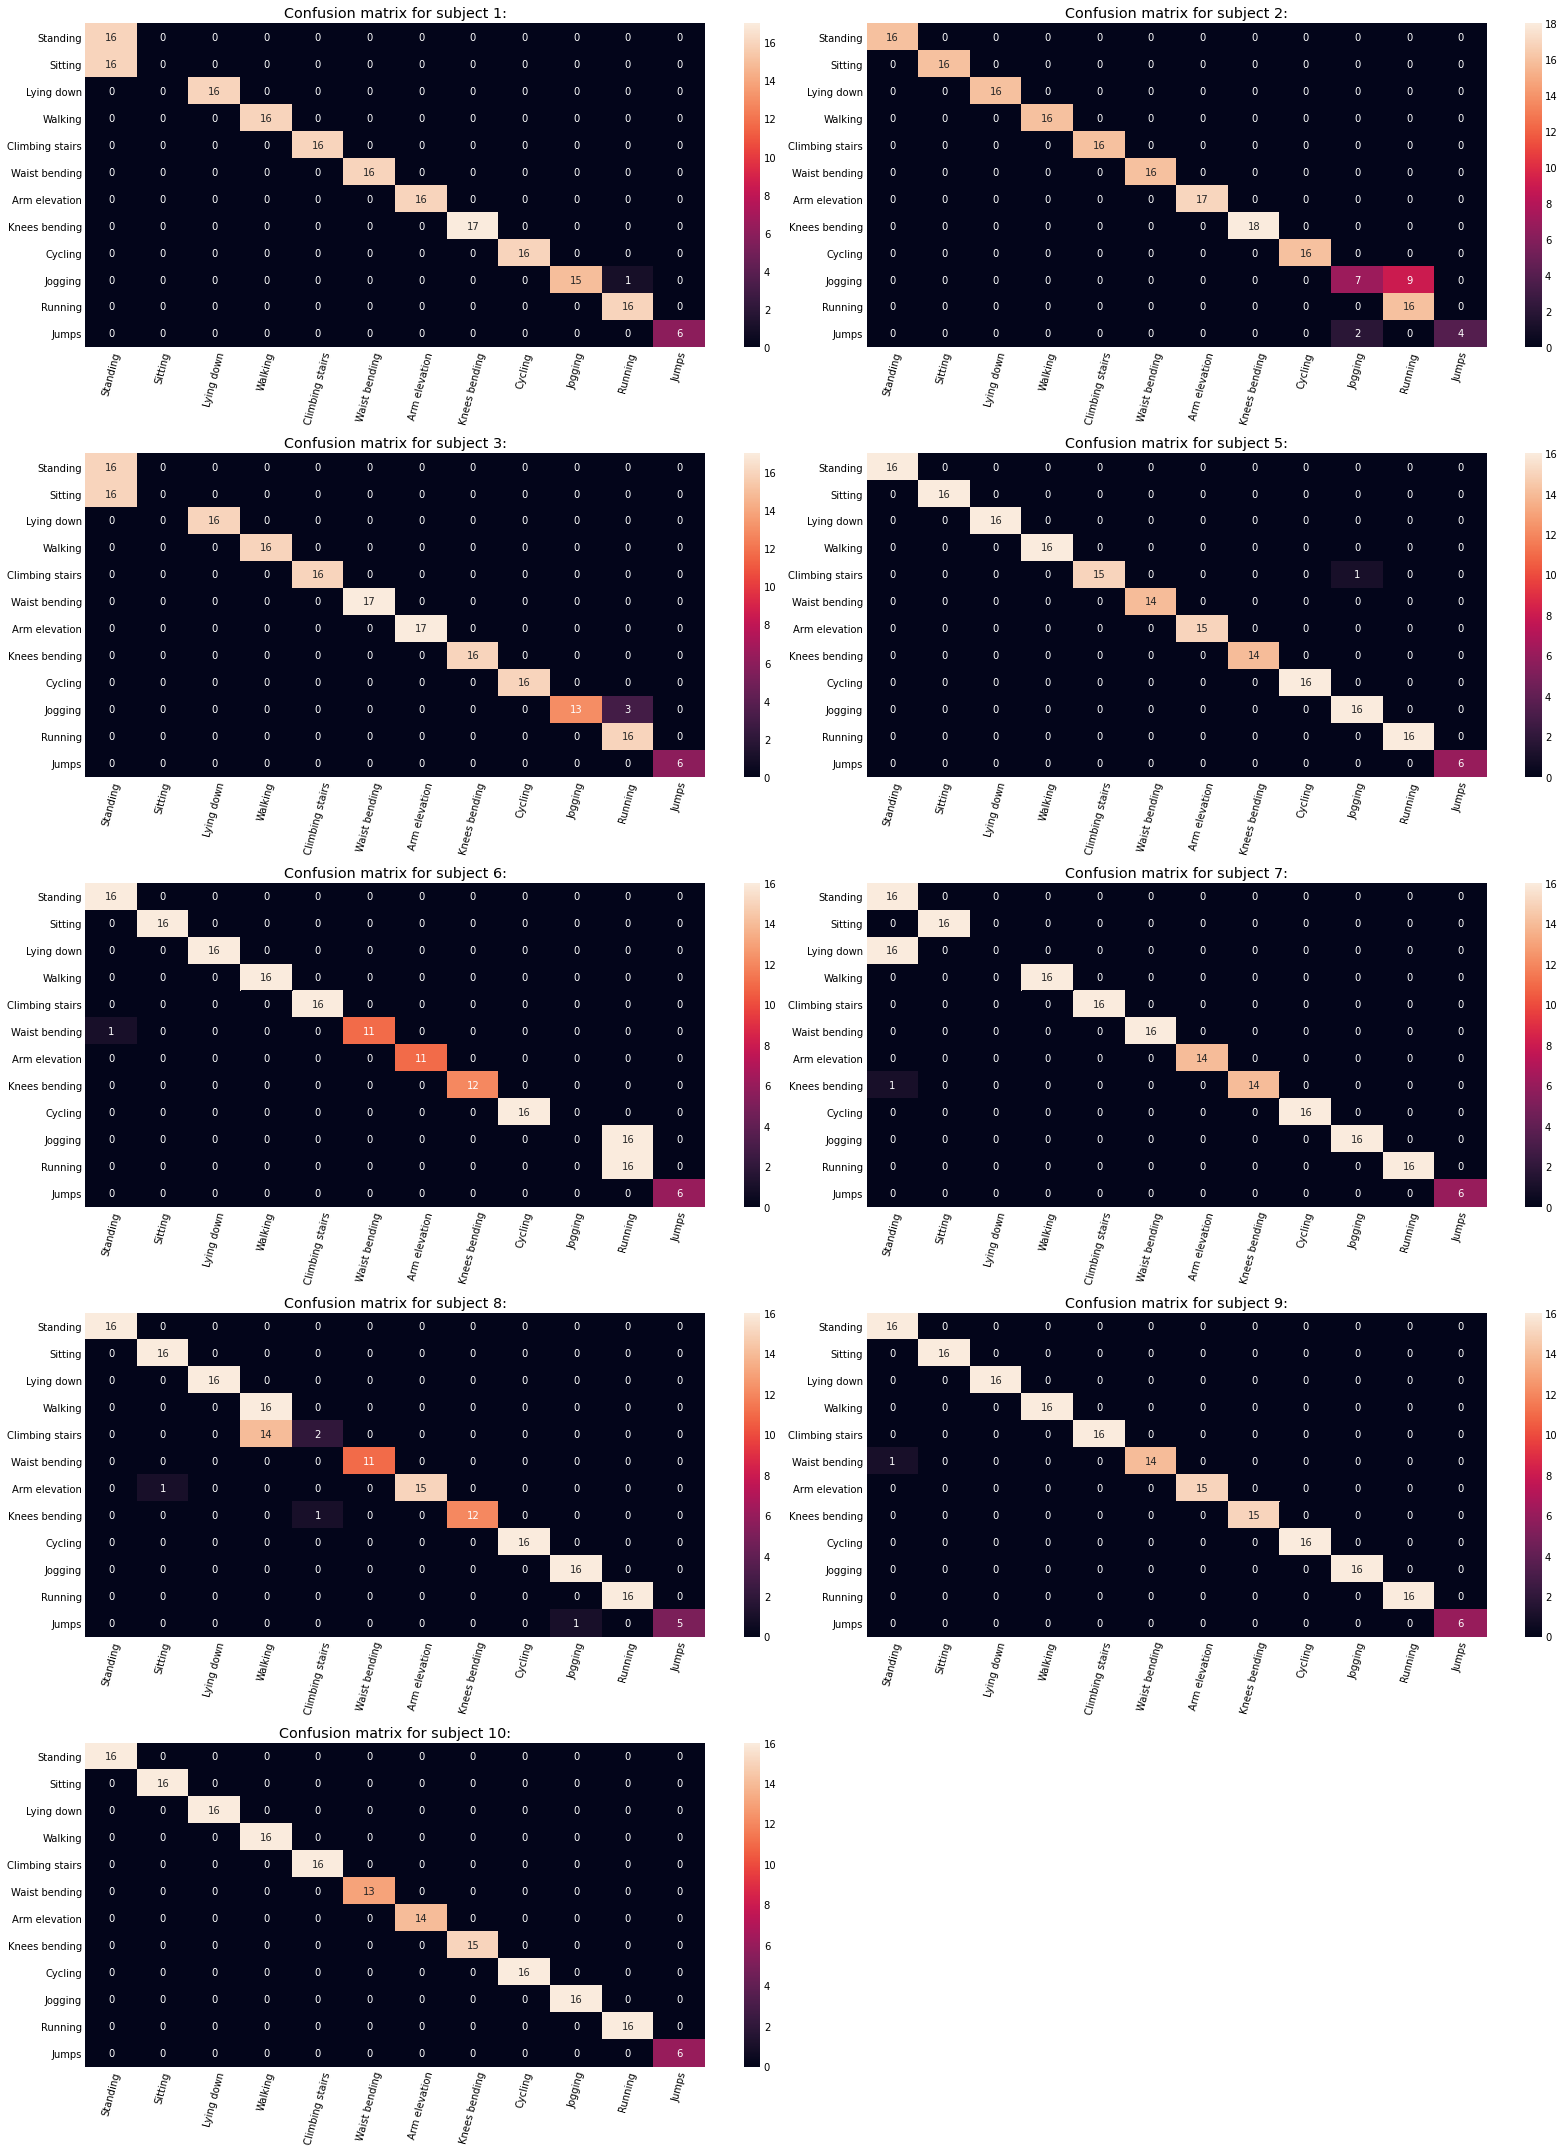

In [136]:
plot_confmat_by_subject(logreg_scores[1])

The type of mistakes made vary by subject. For subject 1 and 3, Standing and Sitting are totally confused, whereas for other subjects, Running and Jogging are confused, or Walking and Climbing stairs. The activities that get confused are in most cases similar in their movement pattern, though. 


Now, let's plot the aggregated confusion matrix over all subjects.

In [137]:
# Helper function to find the max value on the off-diagonal matrix entries - use this value as the max value
# for the colormap inside the heatmap

def find_max_val(mat):
    max_val = 0
    for i in range(mat.shape[0]):
        for j in range(mat.shape[0]):
            if (i != j ) & ( mat.iloc[i,j] > max_val):
                max_val = mat.iloc[i,j]
    return max_val

def get_aggregated_confmat(confmats):
    """Aggregate the confusion matrices of all subjects."""
    agg_confmat = pd.DataFrame(np.array(confmats).sum(axis=0), index=activities_index, columns=activities_index)
    return agg_confmat

def plot_confmat(agg_confmat, figsize=(12,9), fmt='.0f', cmap='hot', ax=None):
    # If no axes is fed as a parameter, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    return sns.heatmap(agg_confmat, annot=True, fmt=fmt, vmax= 1.1 * find_max_val(agg_confmat), cmap=cmap, ax=ax)

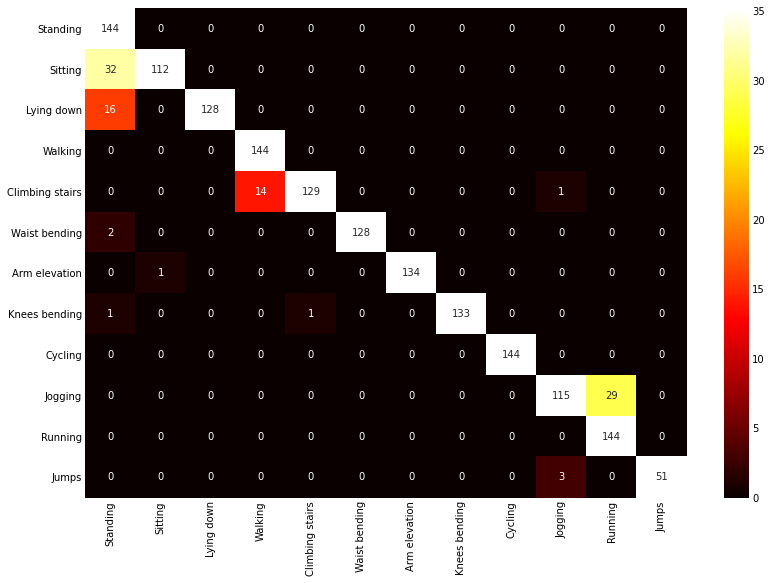

In [140]:
logreg_confmat = get_aggregated_confmat(logreg_scores[1])
plot_confmat(logreg_confmat)
plt.show()

The off-diagonal entries tell us which classes were confused with each other most often.

We can also visually check the aggreagted precision and recall by class, and the proportion of false positives and false negatives attributed to different classes.

In [145]:
def get_global_precision_matrix(agg_confmat):
    """Plots global precision values on the diagonal and percentage of false positives that are of a different class
    in the columns"""
    
    global_precision = agg_confmat.divide(agg_confmat.sum(axis=0))
    
    return global_precision

def get_global_recall_matrix(agg_confmat):
    """Plots global recall values on the diagonal and percentage of false negatives attributed to different classes
    in the rows"""
    global_recall = agg_confmat.divide(agg_confmat.sum(axis=1), axis=0)
    return global_recall

def global_f1(global_precision, global_recall):
    """ Calculate global F1-scores by class """
    
    global_precision = np.diag(global_precision)
    global_recall = np.diag(global_recall)
    global_f1 = (2 * global_precision) * global_recall / (global_precision + global_recall)
    return pd.Series(global_f1, index=activities_index)

<AxesSubplot:>

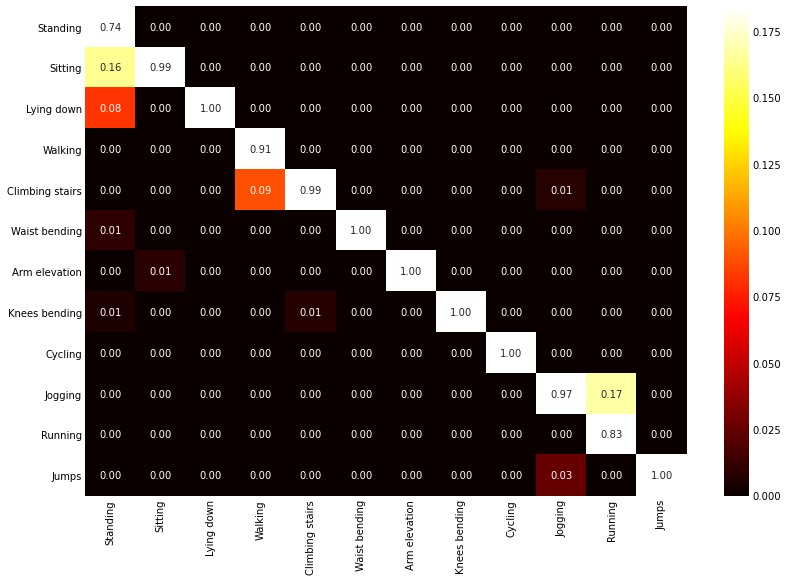

In [142]:
precision_by_class = get_global_precision_matrix(logreg_confmat)
plot_confmat(precision_by_class, fmt='.2f')
plt.show()

16 % of predictions for standing are actually subjects sitting, 17 % of Running predictions actually people jogging, etc. Classes "Lying down", "Waist bends", "Knees bending", "Arm elevation" and "Jumps" have perfect precision.

<AxesSubplot:>

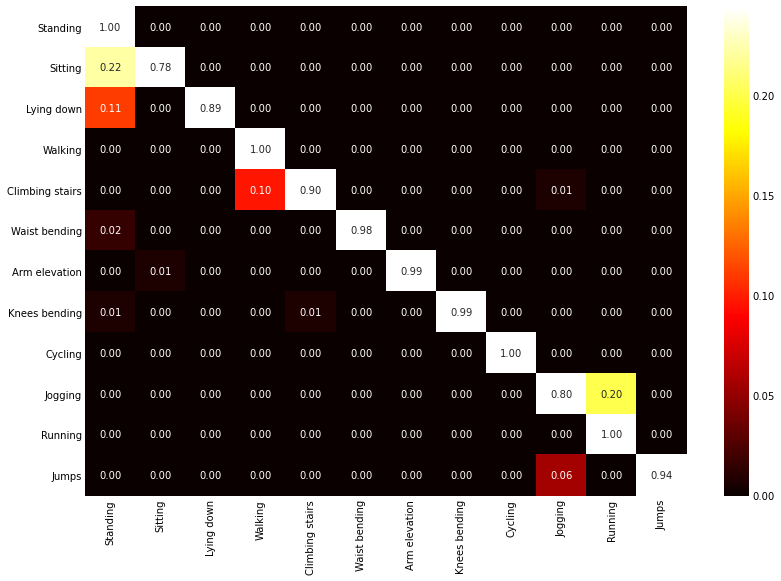

In [242]:
recall_by_class = get_global_recall_matrix(logreg_confmat)
plot_confmat(recall_by_class, fmt='.2f')
plt.show()

For recall the reference is the actual class, so the rows sum to 1. We can see the recall of each class on the diagonals, while the rows show the percentage of non-recalled instances per class that were attributed to wrong activities. Logically, the pattern looks quite similar to the previous plot.

In [146]:
print(f'Global F1 scores logistic regression:\n{global_f1(precision_by_class, recall_by_class)}')

Global F1 scores logistic regression:
Standing           0.849558
Sitting            0.871595
Lying down         0.941176
Walking            0.953642
Climbing stairs    0.941606
Waist bending      0.992248
Arm elevation      0.996283
Knees bending      0.992537
Cycling            1.000000
Jogging            0.874525
Running            0.908517
Jumps              0.971429
dtype: float64


### Plot feature importance

The coefficients of logistic regression yield back direct information about the importance of the included attributes for the classification task. In a multiclass setting, we get back separate coefficients for each class.

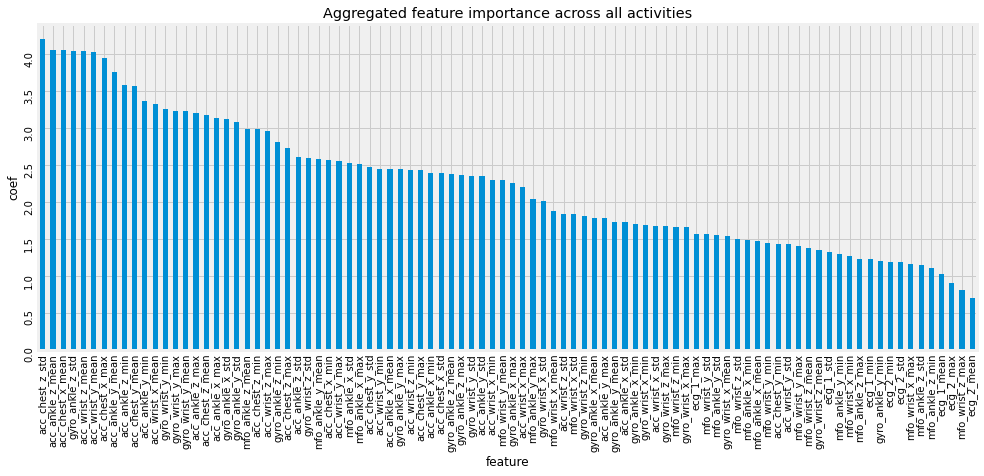

In [250]:
coefs_per_label = pd.DataFrame(data=pipeline[1].coef_, columns=train_set.columns, index=activites_index)

# Aggregated feature importance across all activities
col_sums = coefs_per_label.abs().sum(axis=0)

col_sums.sort_values(ascending=False).plot.bar(figsize=(15,6),
                                              title='Aggregated feature importance across all activities',
                                              ylabel='coef', xlabel='feature')
plt.tick_params(labelrotation=90)

For the logistic regression model, accelearation variables have the most influence on the prediction, followed by turn rate variables. Magnetic field orientation is less important. The ECG values are not particularly important for the prediction.

#### Does PCA improve performance?

In [ ]:
# Make a pipeline to test different number of components
components_to_test = list(range(8,93,5))

pca_scores = {}
for c in components_to_test:

    pca = PCA(n_components=c)
    pipeline = make_pipeline(scaler,pca,clf)
    pca_scores[c] = np.mean(get_scores(pipeline, train_set, target_train, groups_train)[0])

In [151]:
pca_scores

{8: 0.8028501839547104,
 13: 0.8905117781984493,
 18: 0.9094131258665215,
 23: 0.9202096153385223,
 28: 0.9275508160363931,
 33: 0.9220412978579462,
 38: 0.9214305850157832,
 43: 0.9221854980586988,
 48: 0.9216020543881486,
 53: 0.9216020543881486,
 58: 0.9216020543881486,
 63: 0.9222133874908494,
 68: 0.9222127807142468,
 73: 0.9228447109649456,
 78: 0.9222127807142468,
 83: 0.9228447109649456,
 88: 0.9222295190277675}

No improvement when using PCA. Hence, it will be left out for future models.

### Other classifiers

In [ ]:
random_state = 42
models, scores = [], {}
models.append(('SVM', SVC(random_state = random_state)))
models.append(('Ridge', RidgeClassifier(random_state = random_state)))
models.append(('SGD', SGDClassifier(loss='log', random_state = random_state)))
models.append(('XGBClassifier', xgb.XGBClassifier(objective='multi:softmax', eval_metric='merror', seed=random_state)))

for name, model in models :
    pipeline = make_pipeline(scaler,model)
    scores[name] = np.mean(get_scores(pipeline, train_set, target_train, groups_train)[0])

In [155]:
scores

{'SVM': 0.9362906288881597,
 'Ridge': 0.9198948114003191,
 'SGD': 0.9111163216462516,
 'XGBClassifier': 0.9409404205169483}

The XGBoost classifier achieves the best performance with default parameters. That's why in the following, I will focus on XGBoost and Light GBM, another sophisticated gradient boosting algorithm.

### Gradient Boosting: XGBoost & LightGBM

We will use the native XGBoost API in the following since it offers a nice feature to prevent overfitting.

In [157]:
# We need to encode the label to [0,11] because XGBoost and LGBM APIs expects so.
label_encoder = LabelEncoder().fit(target_train)
                                   
target_train_le = label_encoder.transform(target_train)
target_test_le = label_encoder.transform(target_test)

Both gradient boosting models have a lot of hyperparameters to choose. We will search for the best parameters by means of Bayesian Optimization later.

Fortunately, XGBoost and LGBM provide a nice way to find the best number of boosting rounds (aka. number of trees) whilst training. Since the trees are built sequentially, instead of fixing the number of rounds at the beginning, we can validate our model after each new tree that was built and see if adding a new tree improves performance. If performance did not increase for a specified number of rounds, training will be stopped early.

In [251]:
# Maximum number of boosting rounds/trees, if early stopping does not stop the training process earlier
NUM_BOOST_ROUNDS = 999
EARLY_STOPPING = 10

def train_xgb(params, dtrain, dval):
    model = xgb.train(
                    params,
                    dtrain,
                    num_boost_round=NUM_BOOST_ROUNDS,
                    evals=[(dval, "Test")],                  # evaluate performance against this dataset
                    early_stopping_rounds=early_stopping,    # if metric did not improve for 10 rounds 
                            )
    print("Best misclassification error: {:.2f} with {} rounds".format(
         model.best_score,
         model.best_iteration+1))
    return model

def train_lgbm(params, dtrain, dval):
    model = lgb.train(
                    params,
                    dtrain,
                    num_boost_round=NUM_BOOST_ROUNDS,
                    valid_sets=[dval],
                    valid_names=['test'],
                    early_stopping_rounds=EARLY_STOPPING,
                            )
    print("Best misclassification error: {:.2f} with {} rounds".format(
             model.best_score['test']['multi_error'],
             model.best_iteration+1)) 
    return model

In [252]:
# A function to get scores for gradient boosting algorithms - either XGB or LGBM
def get_scores_gb(params, features, target, groups, xgboost=True):
    """Get scores for XGB models, using the native XGB API"""
    
    scores_val = []
    confmats = []

    for train_index, test_index in tqdm(logo.split(features, target, groups)):

        X_train, X_val = features.iloc[train_index], features.iloc[test_index]
        y_train, y_val = target[train_index], target[test_index]
        
        if xgboost:
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)
            model = train_xgb(params,dtrain, dval)
            score_val = model.predict(dval)
        else:
            dtrain = lgb.Dataset(X_train, label=y_train)
            dval = lgb.Dataset(X_val, label=y_val)
            model = train_lgbm(params,dtrain, dval)
            score_val = model.predict(X_val)
            
        preds_val = np.argmax(score_val, axis=1)
        f1_val = metrics.f1_score(y_val,preds_val, average='weighted')
        scores_val.append(f1_val)
        confmats.append(metrics.confusion_matrix(y_val, preds_val))
        
        print(f'{class_report(y_true=y_val, y_pred=preds_val, y_score=score_val, average="macro")}')
    
    # return also the fitted booster (to be used for plotting feature importance)
    return scores_val, confmats, model

Let's use XGBoost with standard parameters first

In [163]:
xgb_params = {
        'eval_metric' : "mlogloss", # Tried with mlogloss and merror and mlogloss achieved better performance.
        'objective' : 'multi:softprob',
        'num_class' : target_train.nunique(),
        'seed' : 42,
            }

In [ ]:
xgb_scores = get_scores_gb(xgb_params, train_set, target_train_le, groups_train, xgboost=True)

In [ ]:
print(f'Train score XGB: {np.mean(xgb_scores[0])} +- {np.std(xgb_scores[0])}')

In [165]:
print(f'Train score XGB: {np.mean(xgb_scores[0])} +- {np.std(xgb_scores[0])}')

Train score XGB: 0.9403154263393267 +- 0.05603092151628114


### Light GBM

As an alternative, I will use Light GBM. LGBM is known for faster training time and also uses a slightly different splitting schmeme for Gradient Boosting (reference article) 

In [253]:
lgb_params = {
    'metric' :  "multi_error",
    'objective' : 'multiclass',
    'num_class' : target_train.nunique(),
    'seed' : 42,
            }

In [ ]:
lgb_scores = get_scores_gb(lgb_params, train_set, target_train_le, groups_train, xgboost=False)

In [170]:
print(f'Train score lgb: {np.mean(lgb_scores[0])} +- {np.std(lgb_scores[0])}')

Train score lgb: 0.9431628102289566 +- 0.0577338876477318


Explore the confusion matrix:

In [254]:
lgb_scores_agg = get_aggregated_confmat(lgb_scores[1])
xgb_scores_agg = get_aggregated_confmat(xgb_scores[1])

precision_lgb = get_global_precision_matrix(lgb_scores_agg)
precision_xgb = get_global_precision_matrix(xgb_scores_agg)

recall_lgb = get_global_recall_matrix(lgb_scores_agg)
recall_xgb = get_global_recall_matrix(xgb_scores_agg)

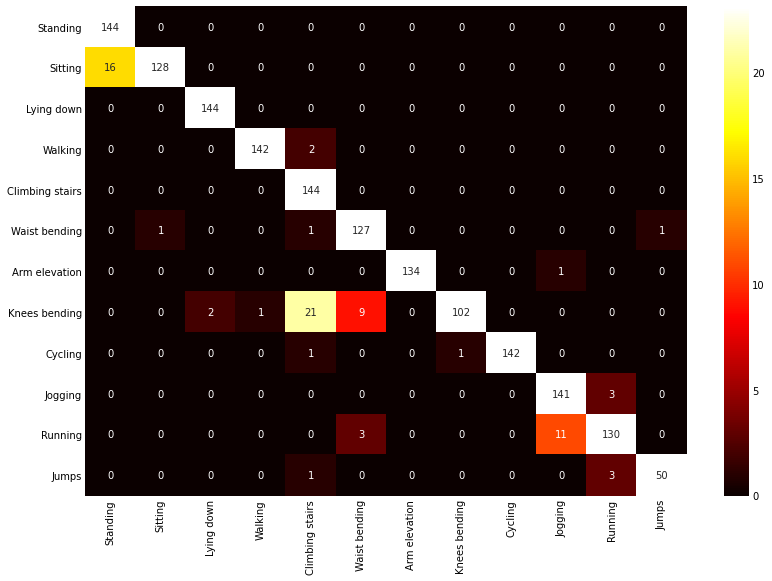

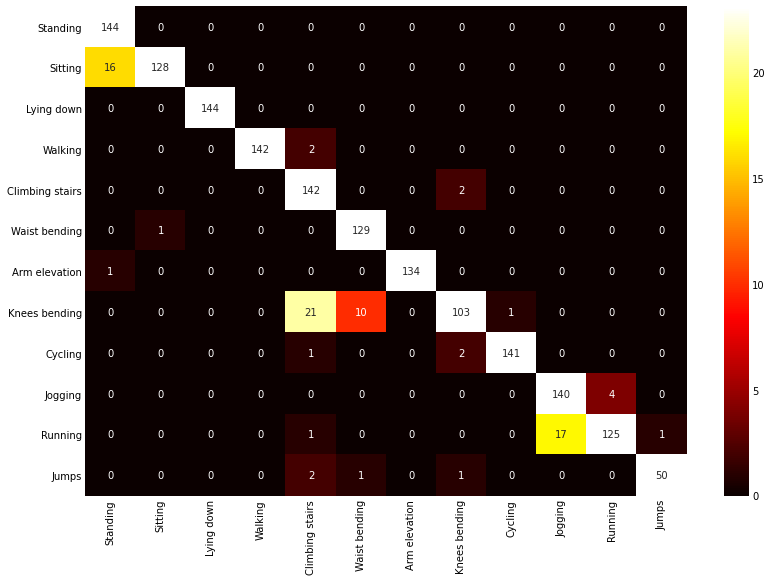

In [259]:
plot_confmat(lgb_scores_agg, fmt='.0f')
plot_confmat(xgb_scores_agg, fmt='.0f')
plt.show()

Let's look at the mistakes our models make:

- Sitting is confused at times as sitting
- Climbing stairs is mistaken as someone bending their knees. So is waist bending

- Jogging and running are activities that get confused with each other the most, in relative terms. This not really suprising, since those activities are quite alike in their movement patterns and jogging/running can differ by subject depending on physical condition. For example, someone physically fit might jog with an intensity that resembles someone who is physically unfit who is running.

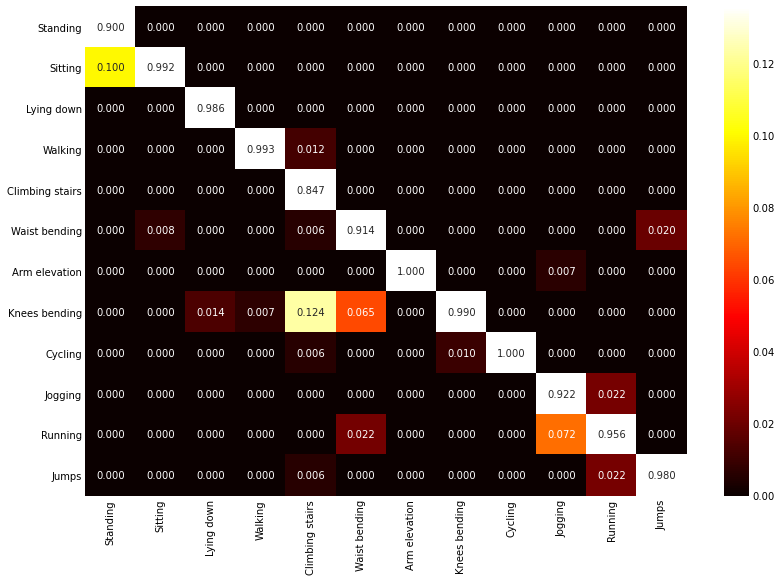

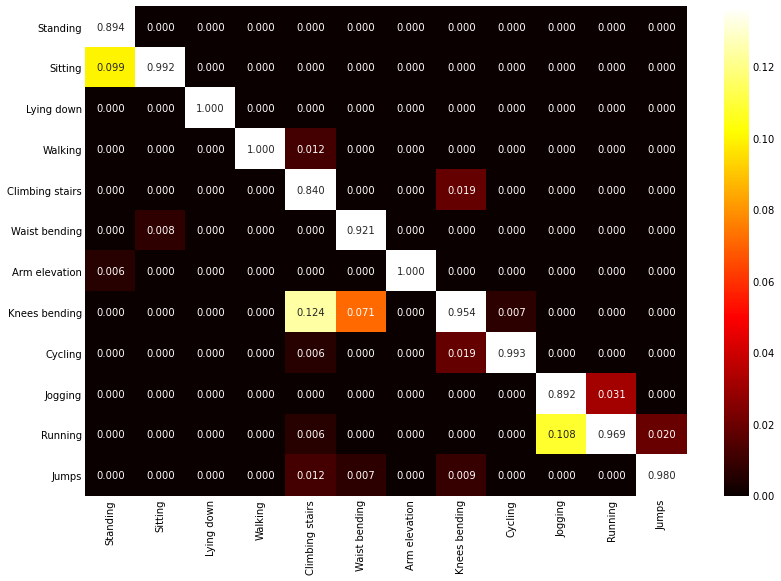

In [260]:
plot_confmat(precision_lgb, fmt='.3f')
plot_confmat(precision_xgb, fmt='.3f')
plt.show()

Both models show very similar performance in terms of precision.

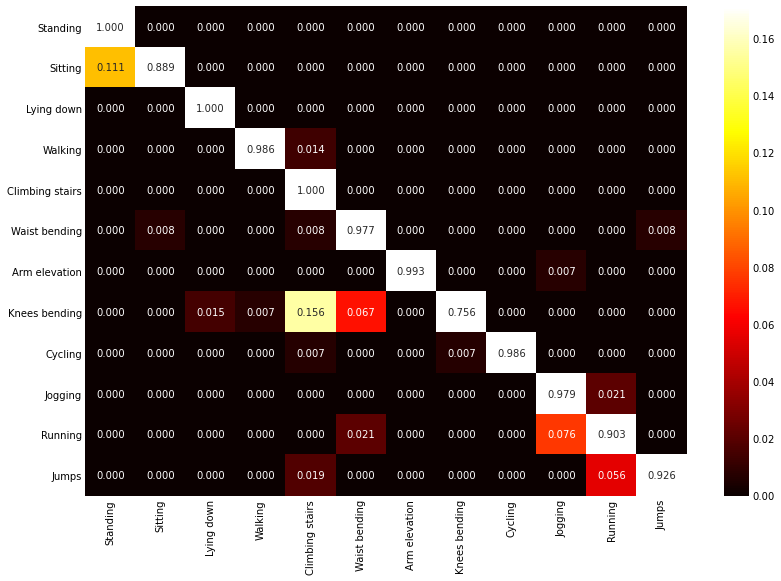

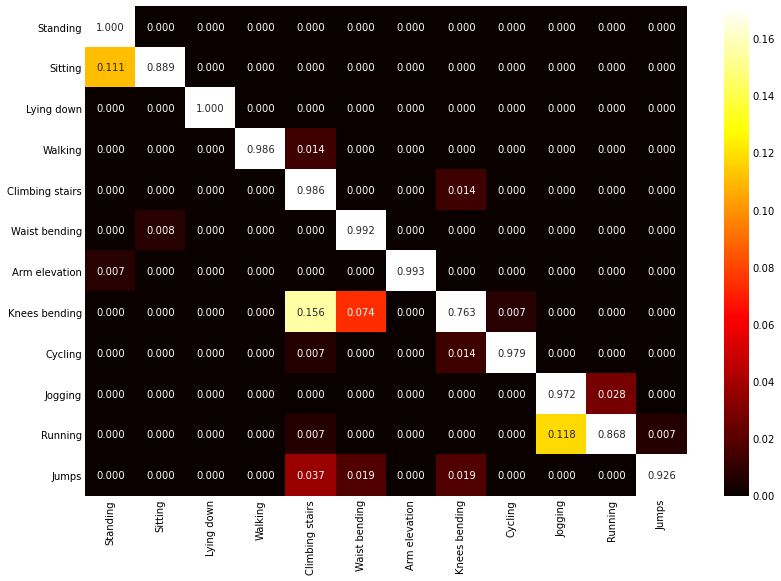

In [261]:
plot_confmat(recall_lgb, fmt='.3f')
plot_confmat(recall_xgb, fmt='.3f')
plt.show()

Same for recall.

In [ ]:
global_f1(precision_lgb, recall_lgb)

In [ ]:
global_f1(precision_xgb, recall_xgb)

Very similar as well. The largest difference occurs for the class Jogging(LGBM 0.949 vs. XGB 0.930).

## Hyperparameter tuning

#### XGBoost
Most parameters in xgboost revolve around the bias-variance tradeoff. As to the official documentation (https://xgboost-clone.readthedocs.io/en/latest/param_tuning.html), there are in general two ways to control overfitting:

1) Directly control model complexity by settting parameters that affect the architecture of the trees, namely *max_depth*, *min_child_weight* and *gamma*.

2) Add randomness to make training robust to noise. This is achieved by setting *subsample* or *colsample_bytree*, through which only use a specified subsample of the training instances are used when growing trees instead of all training instances.

Additionally, we will tune the *learning rate* and the regularization parameters *lambda* and *alpha*.

#### Light GBM

In LGBM models, *num_leaves* (default 31) is the main parameter to control the complexity of a tree model. Besides, *min_data_in_leaf* (default 20) is very important to prevent overfitting in a leaf-wise tree. Trade-off between over- (too small) and underfitting (too large).

for better accuracy:
- small learning rate (default 0.1) with large num_boost_round
- max_bin (default 255): max number of bins that feature values will be bucketed in

### Bayesian Optimization



I will use Bayesian Optimization (BO) for hyperparameter tuning. In BO, the next hyperparameters are chosen in an informed way. Thus, more time is spent evaluating areas of the parameter distribution that are believed to have the highest chance of bringing a score improvement versus previous iterations.(https://www.kaggle.com/prashant111/bayesian-optimization-using-hyperopt). This is different from Random Search, as the latter searches the whole parameter space without taking previous scores into account.

In [180]:
from hyperopt import STATUS_OK, tpe, hp, Trials, fmin

# Define the objective function to be minimized

def objective_function_xgb(params):
    score = np.mean(get_scores_gb(params, train_set, target_train_le, groups_train, xgboost=True)[0])
        
    print("weighted f1-score:", score)
    return {'loss': -score, 'status': STATUS_OK} 

def objective_function_lgb(params):
    score = np.mean(get_scores_gb(params, train_set, target_train_le, groups_train, xgboost=False)[0])
        
    print("weighted f1-score:", score)
    return {'loss': -score, 'status': STATUS_OK} 

In [181]:
xgb_space= {
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 2, 8, 1),
    'gamma': hp.uniform ('gamma', 1,9),
    'objective':'multi:softprob',
    'eval_metric' : "mlogloss",
    'num_class' : target_train.nunique(),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'subsample' : hp.uniform('subsample', 0.8, 1.0),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.4, 1.0),
    'eta' : hp.loguniform('eta', np.log(0.01), np.log(0.3)),
    'reg_alpha' : hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda' : hp.uniform('reg_lambda', 0.0, 1.0),
#     'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
        }


In [ ]:
num_eval = 12

trials = Trials()

best_param = fmin(objective_function_xgb, xgb_space, algo=tpe.suggest, max_evals=num_eval, trials=trials, rstate= np.random.RandomState(42))

In [183]:
best_param

{'colsample_bytree': 0.8830090110836204,
 'eta': 0.03712058849718399,
 'gamma': 3.397258368672401,
 'learning_rate': 0.28293638450342123,
 'max_depth': 2,
 'min_child_weight': 3.0,
 'reg_alpha': 0.16360717863855023,
 'reg_lambda': 0.9393697376027715,
 'subsample': 0.9468056035971136}

In [262]:
best_xgb_params = {**best_param, **xgb_params}

best_xgb_train_score = get_scores_gb(best_xgb_params, train_set, target_train_le, groups_train)

In [190]:
print(f'Train score with best XGB parameters: {np.mean(best_xgb_train_score[0])} +- {np.std(best_xgb_train_score[0])}')

Train score with best XGB parameters: 0.9485424804277583 +- 0.03525139344484061


In [191]:
# Test performance
dtrain = xgb.DMatrix(train_set.select_dtypes(float), label=target_train_le)
dtest = xgb.DMatrix(test_set.select_dtypes(float), label=target_test_le)
best_xgb_model = xgb.train(best_xgb_params, dtrain, num_boost_round=45)

preds_xgb = best_xgb_model.predict(dtest)
preds_xgb = np.argmax(preds_xgb, axis=1)
f1_val_xgb = metrics.f1_score(target_test_le, preds_xgb, average='weighted')

0.9059021214030665

In [193]:
print(f'Test score with best XGB params: {f1_val_xgb}')

Test score with best XGB params: 0.9059021214030665


### Hyperparam search for LGBM

In [196]:
# Define the search space
lgb_space = {
    'max_bin': hp.choice('max_bin', np.arange(50, 500, dtype=int)),
    'num_leaves': hp.choice('num_leaves', np.arange(31, 150, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(20, 500, 5, dtype=int)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'subsample' : hp.uniform('subsample', 0.8, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.4, 1.0),
    'metric' :  "multi_error",
    'objective' : 'multiclass',
    'num_class' : target_train.nunique(),
    'seed' : 42
            }

In [ ]:
num_eval = 12

trials = Trials()
lgbm_best_params = fmin(objective_function_lgb, lgb_space, algo=tpe.suggest, max_evals=num_eval, trials=trials, rstate= np.random.RandomState(42))

In [263]:
trials.average_best_error()

-0.9623319906166211

In [198]:
lgbm_best_params

{'colsample_by_tree': 0.6725021305956136,
 'learning_rate': 0.27524192215258264,
 'max_bin': 425,
 'min_data_in_leaf': 3,
 'num_leaves': 101,
 'reg_alpha': 0.9328679988478337,
 'reg_lambda': 0.727725743177325,
 'subsample': 0.8820207917706627}

In [ ]:
lgbm_best_params = {**lgb_params, **lgbm_best_params}
scores_lgb_best_params = get_scores_gb(lgbm_best_params, train_set, target_train_le, groups_train, xgboost=False)

In [ ]:
dtrain = lgb.Dataset(train_set.select_dtypes(float), label=target_train_le)
dtest = lgb.Dataset(test_set.select_dtypes(float), label=target_test_le)
best_lgbm_model = lgb.train(lgbm_best_params, dtrain, num_boost_round=20)
probabilties_all = best_lgbm_model.predict(test_set)
preds_lgbm = np.argmax(probabilties_all, axis=1)
f1_val = metrics.f1_score(target_test_le, preds_lgbm, average='weighted')

In [265]:
print(f'Train score with best params: {np.mean(scores_lgb_best_params [0])} +- {np.std(scores_lgb_best_params [0])}')
print(f'Test score LGBM: {f1_val}')

Train score with best params: 0.9269057683188104 +- 0.05615985102069065
Test score LGBM: 0.9059021214030665


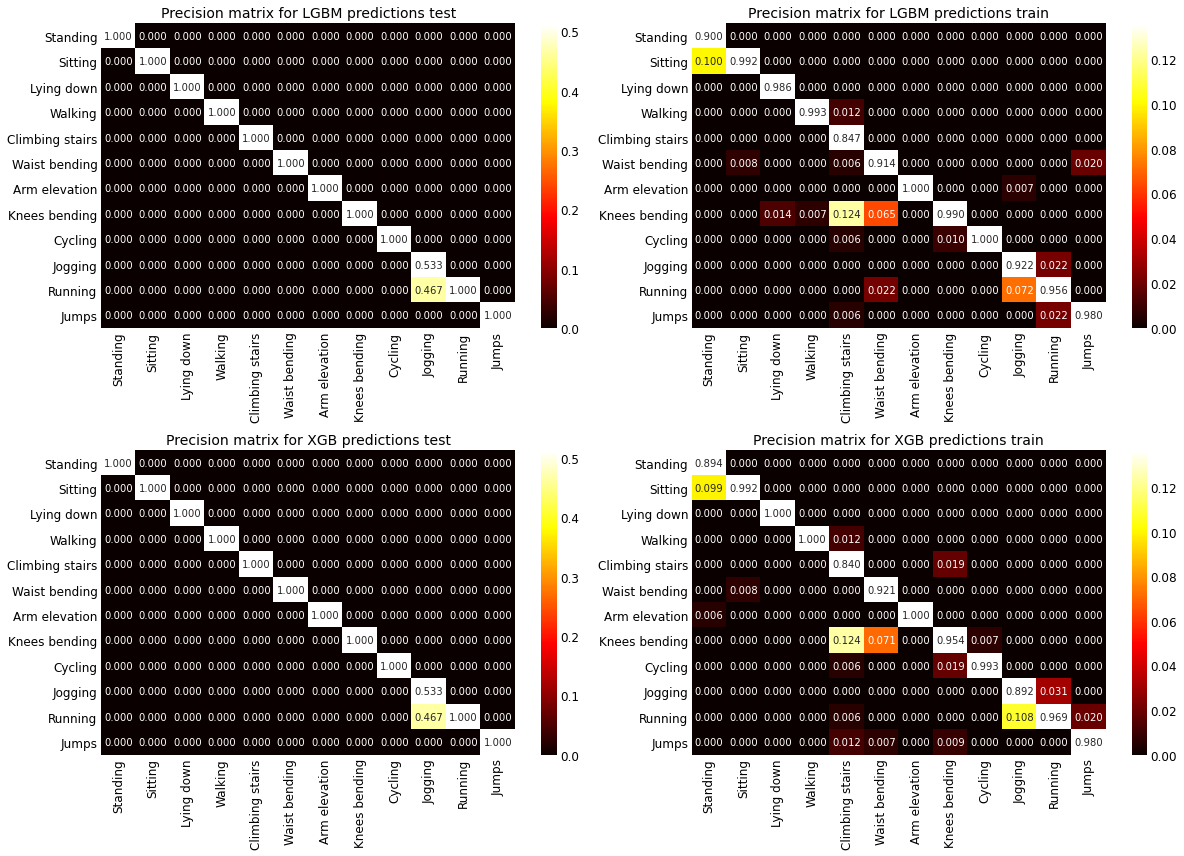

In [271]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(17,12))
lgbm_confmat_test = pd.DataFrame(metrics.confusion_matrix(y_true=target_test_le, y_pred=preds_lgbm), index=activites_index, columns=activites_index)
xgb_confmat_test = pd.DataFrame(metrics.confusion_matrix(y_true=target_test_le, y_pred=preds_xgb), index=activites_index, columns=activites_index)

plot_confmat(get_global_precision_matrix(lgbm_confmat_test), fmt='.3f', ax=axes[0,0])
plot_confmat(get_global_precision_matrix(lgb_scores_agg), fmt='.3f', ax=axes[0,1])
plot_confmat(get_global_precision_matrix(xgb_confmat_test), fmt='.3f', ax=axes[1,0])
plot_confmat(get_global_precision_matrix(xgb_scores_agg), fmt='.3f', ax=axes[1,1])

axes[0,0].set_title('Precision matrix for LGBM predictions test', fontsize=14)
axes[0,1].set_title('Precision matrix for LGBM predictions train', fontsize=14)
axes[1,0].set_title('Precision matrix for XGB predictions test', fontsize=14)
axes[1,1].set_title('Precision matrix for XGB predictions train', fontsize=14)

for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=12)
plt.subplots_adjust(hspace=0.4, wspace=0.3, top=0.95)
plt.tight_layout()

### Feature Importance 
As a last step, let's have a look on the feature importances of the given model:

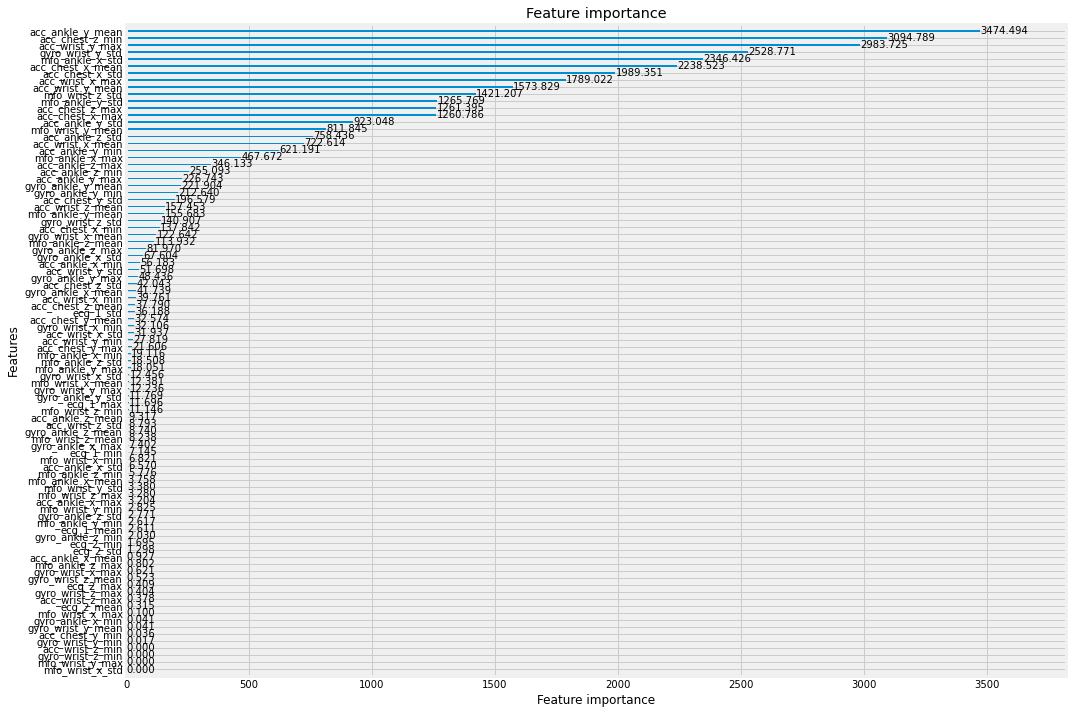

In [215]:
lgb.plot_importance(lgb_scores[2], figsize=(15,12), importance_type='gain')
plt.show()

Text(0, 0.5, 'Feature')

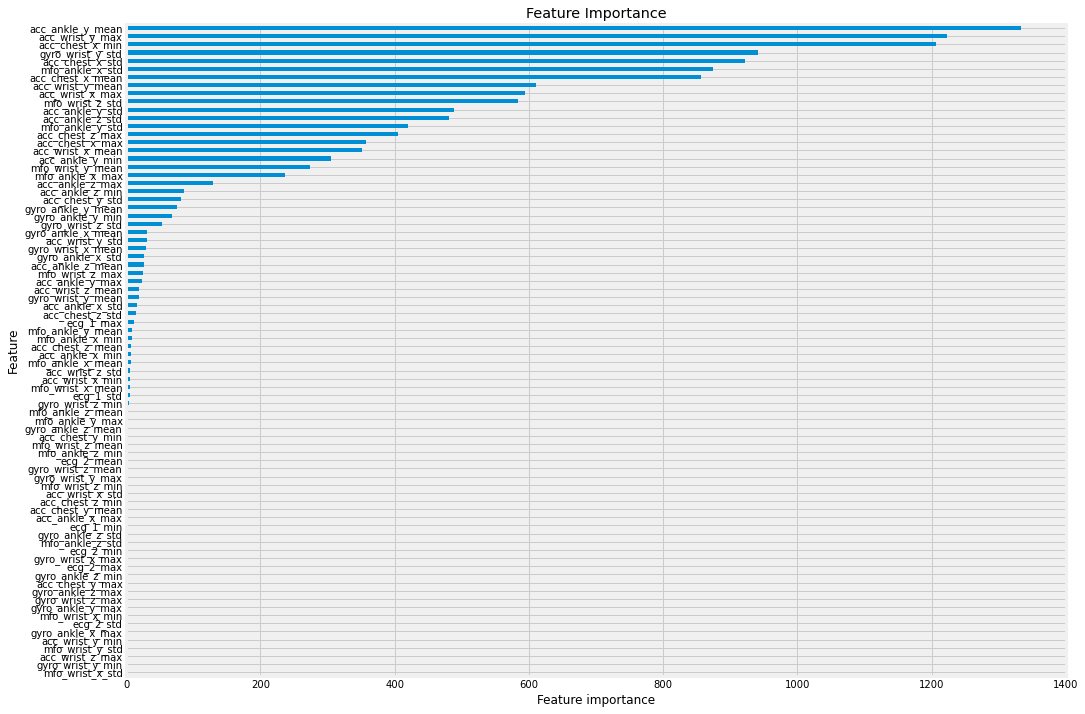

In [217]:
ax = pd.Series(xgb_scores[2].get_score(importance_type="total_gain")).sort_values().plot.barh(figsize=(15,12),
                     title='Feature Importance')
ax.set_xlabel("Feature importance")
ax.set_ylabel("Feature")

### Deep Learning

tbd